## Parser dos dados de Acelerômetro (Ximango e CO)

Do ximango são extraídos os dados de acelerômetro de todos veículos ativos (.csv), não há informação do Ximango sobre data/hora de início/fim de viagem, veículo ou linha.
Os dados das viagens realizadas são extraídos do CO, nesse caso é um período específico por cada veículo.

OBS: No primeiro momento está sendo importado somente dados de ximango e co referente a uma linha específica. (Linha 360)

### 1. Lendo dados Ximango

In [8]:
import pandas as pd
import numpy as np
import matplotlib as plt
from pandas import ExcelWriter
from IPython.display import display, HTML

In [10]:
df = pd.read_csv('/home/rogerio/Teste-Linha360.csv', 
                 sep=r'\,|\;',
                 header=None,
                 usecols=[1,3,4,5,6,7,9,10,11,12,13,14,15,16],
                 engine='python')
df.rename(columns={1:"time", 
                   3:"yn", 
                   4:"lat_yn", 
                   5:"lon_yn", 
                   6:"yp", 
                   7:"lat_yp", 
                   9:"lon_yp", 
                   10:"xn", 
                   11:"lat_xn", 
                   12:"lon_xn", 
                   13:"xp", 
                   14:"lat_xp", 
                   15:"lon_xp", 
                   16:"id"}, 
          inplace=True)
df['time'] = pd.to_datetime(df.time,format='%d%m%y%H%M%S')
df['time'] = df.time + pd.to_timedelta(-2,unit='h')
df['yn'] = df.yn.apply(lambda x: 4294967000+x-4294967296)
df['xn'] = df.xn.apply(lambda x: 4294967000+x-4294967296)
df['id'] = pd.Series(df['id']).str.replace('ID=', '', regex=True)
df['id'] = pd.to_numeric(df['id'])

df.head(2)

time  yn    lat_yn    lon_yn  yp    lat_yp lon_yp  xn  \
0 2018-11-14 14:16:20 -24 -27.57529 -48.42515  15 -27.57503      X -29   
1 2018-11-14 14:16:49 -22 -27.57537 -48.42606  18 -27.57538      X -17   

     lat_xn    lon_xn  xp    lat_xp    lon_xp    id  
0 -27.57496 -48.42337  45 -27.57520 -48.42416  4149  
1 -27.57530 -48.42532  17 -27.57534 -48.42552  4149

### 2. Lendo dados  CO

In [3]:
dfco = pd.read_csv('/home/rogerio/Teste-Linha360CO.csv',
                   header=None,
                   usecols=[0,1,2,3,4,5],
                   engine='python')
dfco.rename(columns={0:"id_v",
                     1:"id",
                     2:"trip_time",
                     3:"line",
                     4:"pc",
                     5:"sentido"},
            inplace=True)
dfco['trip_time'] = pd.to_datetime(dfco.trip_time,format='%d/%m/%y %H:%M:%S')

dfco.head(2)

id_v    id           trip_time  line     pc  sentido
0   275  4080 2018-11-15 13:43:55   360  TILAG        2
1   275  4080 2018-11-15 15:21:55   360   BLAG        2

### 3. Manipulando os dados
#### 3.1 Ximango
Separar os eventos por id (chave externa, virloc)
Para cada id usar os dados de viagem (dt inicio e data fim) do CO para separar as viagens contindas em cada ID.

In [4]:
# remove lat, long (nesse momento não preisa)
df = df[['time', 'yn', 'yp', 'xn', 'xp', 'id']]

# divisão do df em IDs
# minha key será o id do df e o valor é o df.
g = df.groupby('id')

# for g_id, g_id_df in g:
#     # g_id: key 
#     # g_id_df: valores (dataframe separado de cada key)
#     display(g_id)
#     display(g_id_df.head(2))
    
#df.groupby('id').mean()
#df.groupby('id').xp.agg(['count', 'min', 'max','mean', 'std'])

#### 3.2 Estatística de todos os eventos da Linha 360, separado por veículos.

Tabela:

In [19]:
g.agg(['max','min','mean','std'])

yn                           yp                           xn      \
     max min       mean       std max min       mean       std max min   
id                                                                       
3883 -11 -46 -22.307229  6.398547  78  10  15.771084  7.849841 -11 -52   
4080 -11 -42 -24.602410  7.737996  31  10  21.132530  5.091291 -11 -32   
4149 -11 -35 -21.266667  5.286533  85  10  17.638095  7.525756 -12 -52   
4204 -11 -48 -24.445887  7.339907  35  10  16.034632  4.488499 -11 -42   
4209 -11 -52 -21.423841  6.514023  37  10  16.165563  4.195919 -11 -44   
4229 -11 -44 -23.845361  6.267210  46  13  22.752577  6.063949 -11 -32   

                           xp                           
           mean       std max min       mean       std  
id                                                      
3883 -17.078313  6.478862  52  10  20.102410  8.100602  
4080 -17.891566  5.543645  50  10  18.156627  8.052392  
4149 -21.514286  8.192532  64  10  17.628571  8.753304  
4204 -16.619048  5.593660  49  10  19.675325  7.433955  
4209 -18.801325  6.995255  42  10  18.105960  7.440567  
4229 -18.484536  4.928897  50  10  15.216495  5.779322

#### Gráfico do Desvio Padrão de todas as viagens (separados por veículo)

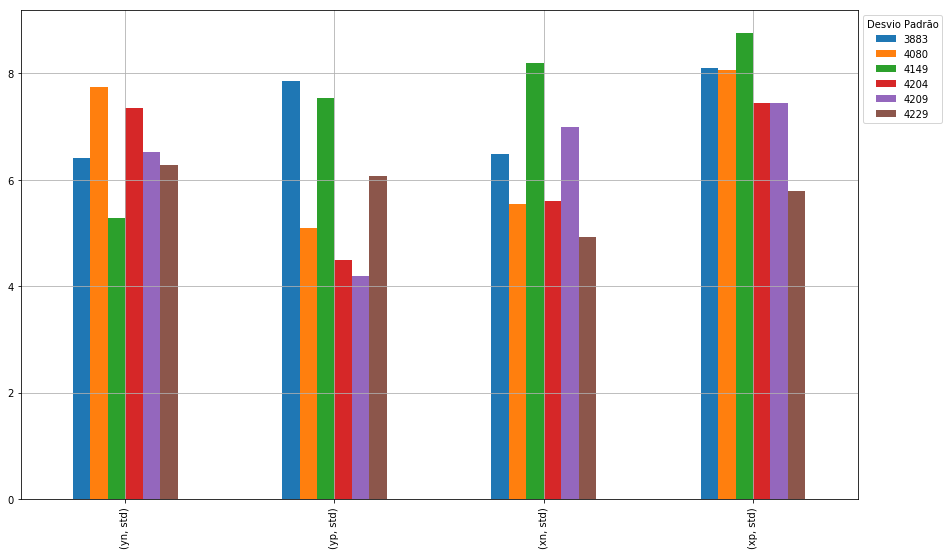

In [17]:
a = g.agg(['std'])
a.reset_index(inplace=True)
a_plot = a.set_index('id').T
a_plot.plot.bar(figsize=(15,9), xticks=range(0, 8), grid=True).legend(title='Desvio Padrão', bbox_to_anchor=(1, 1))


#### Gráfico da Média de todas as eventos (separados por veículo)

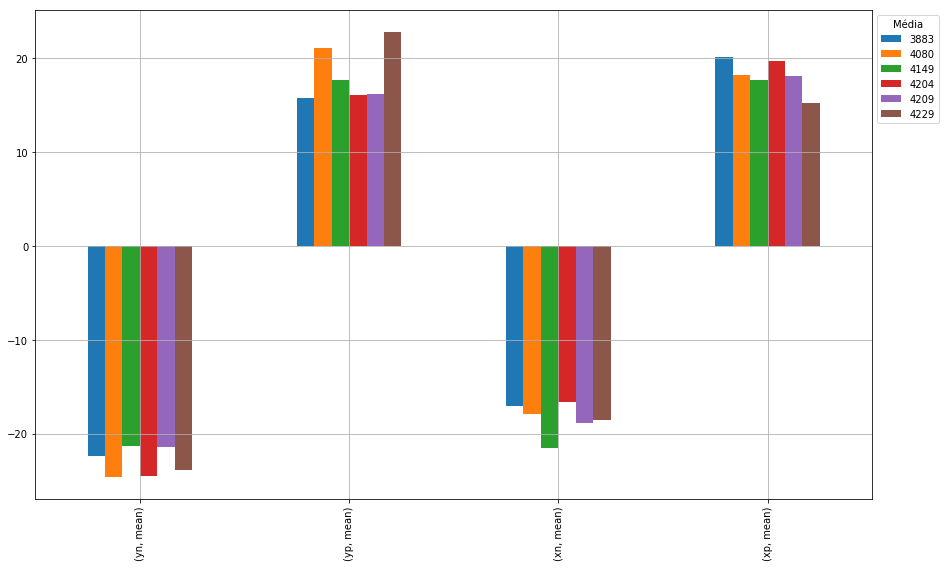

In [7]:
a = g.agg(['mean'])
a.reset_index(inplace=True)
a_plot = a.set_index('id').T
a_plot.plot.bar(figsize=(15,9), grid=True).legend(title='Média', bbox_to_anchor=(1, 1))


#### 3.2 CO
Obter as viagens com data inicio/fim e id veículo.

In [8]:
gco = dfco.groupby('id')

# for gco_id, gco_id_df in gco:
#     # gco_id: key 
#     # gco_id_df: valores (dataframe separado das viagens com cada id veic)
#     display(gco_id)
#     display(gco_id_df)

DataFrame gco está agrupado por id.
Cada id (veículo) possui todas as viagens do período selecionado.
Considerando que <font color='red'>as viagens selecionadas (.csv co) não possuem problema de duplicidade de horário, pc e já estão com índice <b>i</b>  para inicio e índice  <b>i+1</b> para fim</font> o parser cria uma máscara para agrupar os eventos do ximango de acordo com essas viagens.


In [9]:
df_trip = pd.DataFrame({'id_v':[], 'id':[], 'start':[], 'end':[]})

# em cada veículo
for gco_id, gco_id_df in gco:
    # em cada evento (viagens de cada veículo)
    for i in range(0, len(gco_id_df)-1, 2):
        start_date = gco_id_df.iloc[i]['trip_time']
        end_date = gco_id_df.iloc[i+1]['trip_time']
        id_v = gco_id_df.iloc[i]['id_v']
        df_trip = df_trip.append({'id_v':id_v, 'id':gco_id, 'start':start_date, 'end':end_date}, ignore_index=True)
        i = i + 2

Dataframe df_trip contém o início e final de cada viagem.

In [10]:
df_trip['id'] = df_trip['id'].astype(np.int64)
df_trip['id_v'] = df_trip['id_v'].astype(np.int64)

df_trip.head(10)

id_v    id               start                 end
0  50331  3883 2018-11-14 19:27:20 2018-11-14 19:49:12
1  50331  3883 2018-11-14 20:02:57 2018-11-14 20:23:36
2  50331  3883 2018-11-14 22:46:02 2018-11-14 23:12:52
3  50331  3883 2018-11-14 23:14:00 2018-11-14 23:29:36
4  50331  3883 2018-11-14 23:47:20 2018-11-15 00:10:23
5  50331  3883 2018-11-16 19:07:21 2018-11-16 19:31:18
6  50331  3883 2018-11-16 19:41:22 2018-11-16 20:54:30
7    275  4080 2018-11-15 13:43:55 2018-11-15 15:21:55
8    275  4080 2018-11-17 11:28:55 2018-11-17 12:05:46
9    275  4080 2018-11-17 12:07:35 2018-11-17 12:40:47

### 4. Visualização e Resultados

#### 4.1 Eventos de acelerômetro separado por viagem

In [11]:
count = 0
for i in range(len(df_trip)):
    start_date = df_trip.iloc[i]['start']
    end_date = df_trip.iloc[i]['end']
    mask = (df['time'] > start_date ) & (df['time'] < end_date )
    df_vg = df.loc[mask]
    if df_vg.count()['yn'] != 0:
        display("Veículo: {}/{} || Dur: {} || Início: {} Fim: {}" .format(df_trip.iloc[i]['id'],
                                                                      df_trip.iloc[i]['id_v'],
                                                                      (df_trip.iloc[i]['end'] - df_trip.iloc[i]['start']),           
                                                                      df_trip.iloc[i]['start'],
                                                                      df_trip.iloc[i]['end']))
        display(df_vg)
    count = count + 1


'Veículo: 3883/50331 || Dur: 0 days 00:21:52 || Início: 2018-11-14 19:27:20 Fim: 2018-11-14 19:49:12'

time  yn  yp  xn  xp    id
82  2018-11-14 19:27:46 -20  17 -33  22  3883
83  2018-11-14 19:31:31 -20  13 -27  23  3883
84  2018-11-14 19:31:46 -24  12 -13  12  3883
85  2018-11-14 19:32:31 -17  50 -15  15  3883
86  2018-11-14 19:33:01 -22  14 -18  17  3883
87  2018-11-14 19:33:16 -24  16 -11  10  3883
88  2018-11-14 19:33:46 -26  16 -17  13  3883
89  2018-11-14 19:34:31 -23  15 -18  13  3883
90  2018-11-14 19:35:16 -27  20 -17  18  3883
91  2018-11-14 19:35:16 -27  20 -17  18  3883
92  2018-11-14 19:35:46 -25  24 -17  10  3883
93  2018-11-14 19:36:31 -33  13 -33  35  3883
94  2018-11-14 19:38:31 -27  19 -25  30  3883
95  2018-11-14 19:39:01 -18  16 -19  11  3883
96  2018-11-14 19:39:16 -18  11 -12  12  3883
97  2018-11-14 19:40:31 -25  14 -16  19  3883
98  2018-11-14 19:41:31 -30  11 -20  30  3883
99  2018-11-14 19:44:01 -31  18 -11  23  3883
100 2018-11-14 19:45:31 -27  19 -17  25  3883
101 2018-11-14 19:45:46 -25  13 -15  23  3883
102 2018-11-14 19:46:16 -19  16 -12  31  3883
103 2018-11-14 19:46:46 -15  17 -17  24  3883
104 2018-11-14 19:47:01 -25  14 -14  27  3883
105 2018-11-14 19:47:31 -22  17 -14  10  3883

'Veículo: 3883/50331 || Dur: 0 days 00:26:50 || Início: 2018-11-14 22:46:02 Fim: 2018-11-14 23:12:52'

time  yn  yp  xn  xp    id
154 2018-11-14 22:49:46 -28  13 -11  24  3883
155 2018-11-14 22:49:46 -28  13 -11  24  3883
156 2018-11-14 22:53:01 -20  16 -11  12  3883
157 2018-11-14 22:53:31 -13  15 -29  28  3883
158 2018-11-14 22:54:01 -21  17 -15  12  3883
159 2018-11-14 22:54:46 -24  11 -20  10  3883
160 2018-11-14 22:55:31 -40  13 -11  18  3883
161 2018-11-14 22:56:01 -26  11 -15  13  3883
162 2018-11-14 22:56:31 -16  12 -14  14  3883
163 2018-11-14 22:57:01 -31  15 -12  19  3883
164 2018-11-14 22:57:46 -14  10 -18  11  3883
165 2018-11-14 22:58:01 -14  10 -23  17  3883
166 2018-11-14 22:58:31 -15  14 -11  11  3883
167 2018-11-14 22:59:01 -28  14 -13  14  3883
168 2018-11-14 22:59:46 -23  14 -37  32  3883
169 2018-11-14 23:01:31 -27  13 -19  23  3883
170 2018-11-14 23:02:31 -22  17 -27  10  3883
171 2018-11-14 23:04:31 -25  13 -11  17  3883
172 2018-11-14 23:05:01 -24  10 -17  29  3883
173 2018-11-14 23:09:16 -25  16 -17  20  3883
174 2018-11-14 23:09:31 -20  14 -15  17  3883
175 2018-11-14 23:09:46 -12  14 -16  15  3883
176 2018-11-14 23:10:46 -30  18 -11  27  3883
177 2018-11-14 23:11:16 -17  15 -15  26  3883
178 2018-11-14 23:11:31 -22  17 -18  13  3883
179 2018-11-14 23:11:46 -20  14 -13  10  3883
180 2018-11-14 23:12:31 -29  15 -22  22  3883

'Veículo: 3883/50331 || Dur: 0 days 00:15:36 || Início: 2018-11-14 23:14:00 Fim: 2018-11-14 23:29:36'

time  yn  yp  xn  xp    id
181 2018-11-14 23:14:01 -21  16 -15  19  3883
182 2018-11-14 23:14:16 -13  10 -11  18  3883
183 2018-11-14 23:15:01 -23  19 -21  18  3883
184 2018-11-14 23:15:16 -12  14 -18  13  3883
185 2018-11-14 23:15:46 -19  20 -15  24  3883
186 2018-11-14 23:16:01 -15  16 -26  22  3883
187 2018-11-14 23:16:16 -18  14 -11  15  3883
188 2018-11-14 23:16:46 -25  13 -14  21  3883
189 2018-11-14 23:17:01 -17  11 -17  13  3883
190 2018-11-14 23:17:46 -32  16 -14  18  3883
191 2018-11-14 23:18:16 -25  13 -19  15  3883
192 2018-11-14 23:18:31 -26  18 -17  17  3883
193 2018-11-14 23:18:46 -22  12 -17  22  3883
194 2018-11-14 23:19:16 -17  14 -19  24  3883
195 2018-11-14 23:20:31 -25  19 -31  28  3883
196 2018-11-14 23:21:16 -28  10 -14  18  3883
197 2018-11-14 23:21:46 -25  17 -16  42  3883
198 2018-11-14 23:22:31 -20  15 -21  20  3883
199 2018-11-14 23:23:16 -28  11 -37  30  3883
200 2018-11-14 23:23:31 -17  19 -11  21  3883
201 2018-11-14 23:24:16 -18  12 -11  24  3883
202 2018-11-14 23:24:46 -12  12 -12  19  3883
203 2018-11-14 23:25:46 -14  15 -16  18  3883
204 2018-11-14 23:26:01 -12  15 -12  16  3883
205 2018-11-14 23:27:01 -23  14 -14  23  3883
206 2018-11-14 23:27:16 -25  11 -23  46  3883
207 2018-11-14 23:28:01 -23  17 -16  15  3883
208 2018-11-14 23:29:01 -18  22 -17  23  3883
209 2018-11-14 23:29:31 -29  16 -23  40  3883

'Veículo: 3883/50331 || Dur: 0 days 00:23:03 || Início: 2018-11-14 23:47:20 Fim: 2018-11-15 00:10:23'

time  yn  yp  xn  xp    id
210 2018-11-14 23:47:31 -21  11 -16  29  3883
211 2018-11-14 23:47:46 -30  15 -13  12  3883
212 2018-11-14 23:51:31 -25  12 -11  14  3883
213 2018-11-14 23:52:01 -25  10 -13  18  3883
214 2018-11-14 23:52:31 -12  14 -27  28  3883
215 2018-11-14 23:53:01 -26  13 -21  34  3883
216 2018-11-14 23:53:16 -19  20 -15  16  3883
217 2018-11-14 23:54:16 -15  10 -18  19  3883
218 2018-11-14 23:54:31 -14  15 -27  43  3883
219 2018-11-14 23:54:46 -13  14 -18  22  3883
220 2018-11-14 23:55:16 -20  14 -11  13  3883
221 2018-11-14 23:55:31 -11  11 -13  15  3883
222 2018-11-14 23:55:46 -20  10 -15  11  3883
223 2018-11-14 23:56:16 -20  20 -13  10  3883
224 2018-11-14 23:56:31 -17  19 -16  12  3883
225 2018-11-14 23:57:01 -20  17 -22  24  3883
226 2018-11-14 23:57:16 -22  15 -13  22  3883
227 2018-11-14 23:57:31 -22  11 -16  11  3883
228 2018-11-14 23:58:31 -33  16 -35  36  3883
229 2018-11-15 00:00:01 -27  15 -22  25  3883
230 2018-11-15 00:00:16 -23  13 -33  12  3883
231 2018-11-15 00:02:01 -12  19 -12  14  3883
232 2018-11-15 00:03:16 -24  13 -24  26  3883
233 2018-11-15 00:04:46 -24  13 -13  17  3883
234 2018-11-15 00:06:01 -27  20 -11  18  3883
235 2018-11-15 00:07:01 -29  24 -11  22  3883
236 2018-11-15 00:07:31 -27  15 -13  22  3883
237 2018-11-15 00:08:01 -21  14 -23  33  3883
238 2018-11-15 00:08:16 -25  19 -13  10  3883
239 2018-11-15 00:08:46 -26  15 -18  25  3883
240 2018-11-15 00:09:16 -38  20 -16  35  3883
241 2018-11-15 00:09:31 -24  16 -14  12  3883
242 2018-11-15 00:10:01 -26  18 -14  25  3883
243 2018-11-15 00:10:16 -17  15 -27  13  3883

'Veículo: 3883/50331 || Dur: 0 days 00:23:57 || Início: 2018-11-16 19:07:21 Fim: 2018-11-16 19:31:18'

time  yn  yp  xn  xp    id
576 2018-11-16 19:07:31 -30  10 -31  38  3883
577 2018-11-16 19:08:01 -21  11 -16  13  3883
578 2018-11-16 19:09:01 -18  12 -52  17  3883
579 2018-11-16 19:11:01 -15  16 -13  22  3883
580 2018-11-16 19:12:31 -15  10 -21  15  3883
581 2018-11-16 19:13:16 -13  12 -19  21  3883
582 2018-11-16 19:13:46 -11  10 -12  17  3883
583 2018-11-16 19:16:16 -21  11 -14  16  3883
584 2018-11-16 19:17:31 -21  18 -15  27  3883
585 2018-11-16 19:19:16 -24  14 -28  26  3883
586 2018-11-16 19:22:16 -23  17 -20  16  3883
587 2018-11-16 19:23:31 -33  11 -24  32  3883
588 2018-11-16 19:25:31 -23  16 -15  18  3883
589 2018-11-16 19:26:16 -33  18 -11  15  3883
590 2018-11-16 19:27:01 -22  17 -13  17  3883
591 2018-11-16 19:27:31 -29  20 -21  17  3883
592 2018-11-16 19:28:01 -24  17 -15  13  3883
593 2018-11-16 19:28:31 -26  15 -13  29  3883
594 2018-11-16 19:29:01 -19  18 -13  20  3883
595 2018-11-16 19:29:31 -22  23 -19  19  3883
596 2018-11-16 19:29:46 -20  18 -16  21  3883
597 2018-11-16 19:30:01 -19  11 -17  16  3883
598 2018-11-16 19:30:16 -17  17 -11  10  3883
599 2018-11-16 19:30:46 -22  14 -13  22  3883
600 2018-11-16 19:31:16 -27  17 -11  14  3883

'Veículo: 3883/50331 || Dur: 0 days 01:13:08 || Início: 2018-11-16 19:41:22 Fim: 2018-11-16 20:54:30'

time  yn  yp  xn  xp    id
601 2018-11-16 19:42:31 -20  14 -19  16  3883
602 2018-11-16 19:43:01 -16  12 -12  18  3883
603 2018-11-16 19:43:16 -25  13 -12  11  3883
604 2018-11-16 19:43:46 -15  19 -18  17  3883
605 2018-11-16 19:44:01 -19  10 -12  24  3883
606 2018-11-16 19:44:16 -13  17 -12  22  3883
607 2018-11-16 19:44:31 -23  15 -12  13  3883
608 2018-11-16 19:45:01 -28  14 -20  18  3883
609 2018-11-16 19:45:16 -27  12 -11  19  3883
610 2018-11-16 19:45:46 -19  19 -19  19  3883
611 2018-11-16 19:46:16 -17  13 -13  12  3883
612 2018-11-16 19:47:01 -22  17 -12  21  3883
613 2018-11-16 19:48:01 -22  13 -19  20  3883
614 2018-11-16 19:55:46 -25  73 -13  52  3883
615 2018-11-16 20:00:46 -21  14 -12  10  3883
616 2018-11-16 20:08:31 -24  13 -19  20  4229
617 2018-11-16 20:09:46 -26  21 -23  22  4229
618 2018-11-16 20:10:01 -24  19 -14  17  4229
619 2018-11-16 20:11:31 -46  10 -18  10  3883
620 2018-11-16 20:20:01 -22  25 -17  12  4229
621 2018-11-16 20:24:16 -39  23 -26  15  4229
622 2018-11-16 20:27:01 -24  27 -21  21  4229
623 2018-11-16 20:28:46 -21  78 -18  51  3883
624 2018-11-16 20:30:01 -30  28 -21  10  4229
625 2018-11-16 20:33:01 -32  29 -27  12  4229
626 2018-11-16 20:33:31 -15  17 -15  11  4229
627 2018-11-16 20:34:31 -31  17 -19  19  4229
628 2018-11-16 20:35:16 -22  13 -15  20  3883
629 2018-11-16 20:36:31 -40  24 -13  10  4229
630 2018-11-16 20:37:31 -21  10 -11  14  3883
631 2018-11-16 20:37:46 -32  22 -18  11  4229
632 2018-11-16 20:38:31 -25  20 -14  12  4229
633 2018-11-16 20:38:31 -13  12 -12  19  3883
634 2018-11-16 20:38:46 -19  11 -11  16  3883
635 2018-11-16 20:39:46 -24  26 -15  18  4229
636 2018-11-16 20:40:16 -34  24 -14  14  4229
637 2018-11-16 20:40:46 -22  21 -17  12  4229
638 2018-11-16 20:42:01 -25  20 -22  19  4229
639 2018-11-16 20:43:01 -38  17 -15  12  4229
640 2018-11-16 20:44:16 -45  24 -33  29  3883
641 2018-11-16 20:46:01 -11  12 -11  11  3883
642 2018-11-16 20:49:01 -45  11 -11  15  3883
643 2018-11-16 20:50:16 -18  18 -13  21  3883
644 2018-11-16 20:51:31 -30  15 -17  31  4209
645 2018-11-16 20:52:46 -26  20 -13  27  4209
646 2018-11-16 20:53:16 -22  20 -21  16  4229
647 2018-11-16 20:53:46 -12  18 -12  11  4229
648 2018-11-16 20:53:46 -20  20 -11  22  3883
649 2018-11-16 20:54:16 -21  15 -17  27  3883

'Veículo: 4080/275 || Dur: 0 days 01:38:00 || Início: 2018-11-15 13:43:55 Fim: 2018-11-15 15:21:55'

time  yn  yp  xn  xp    id
299 2018-11-15 13:44:16 -23  20 -15  34  4080
300 2018-11-15 13:49:46 -14  17 -26  10  4080
301 2018-11-15 14:44:16 -15  25 -11  20  4080
302 2018-11-15 14:51:46 -18  23 -12  12  4080
303 2018-11-15 14:56:46 -24  22 -18  10  4080
304 2018-11-15 15:00:01 -31  25 -20  10  4080
305 2018-11-15 15:07:01 -21  16 -16  10  4080
306 2018-11-15 15:08:16 -18  17 -21  26  4080
307 2018-11-15 15:09:46 -17  24 -24  11  4080
308 2018-11-15 15:10:16 -17  30 -24  20  4080
309 2018-11-15 15:11:01 -27  19 -32  33  4080
310 2018-11-15 15:13:16 -19  27 -16  17  4080
311 2018-11-15 15:14:01 -28  19 -16  18  4080
312 2018-11-15 15:15:01 -33  17 -14  18  4080
313 2018-11-15 15:16:01 -22  18 -17  14  4080
314 2018-11-15 15:17:01 -21  26 -12  17  4080
315 2018-11-15 15:18:01 -30  22 -18  20  4080
316 2018-11-15 15:18:16 -17  17 -12  13  4080
317 2018-11-15 15:18:46 -34  18 -22  11  4080
318 2018-11-15 15:19:01 -20  18 -11  29  4080
319 2018-11-15 15:19:16 -20  17 -14  18  4080
320 2018-11-15 15:19:46 -23  17 -22  23  4080
321 2018-11-15 15:20:16 -26  23 -19  11  4080

'Veículo: 4080/275 || Dur: 0 days 00:36:51 || Início: 2018-11-17 11:28:55 Fim: 2018-11-17 12:05:46'

time  yn  yp  xn  xp    id
744 2018-11-17 11:30:31 -28  24 -18  50  4080
745 2018-11-17 11:31:01 -11  20 -11  16  4080
746 2018-11-17 11:31:16 -20  23 -15  15  4080
747 2018-11-17 11:31:46 -15  24 -16  25  4080
748 2018-11-17 11:32:01 -27  30 -29  17  4080
749 2018-11-17 11:32:16 -42  16 -23  16  4080
750 2018-11-17 11:32:46 -30  31 -22  35  4080
751 2018-11-17 11:33:16 -32  12 -28  19  4080
752 2018-11-17 11:35:01 -32  24 -12  22  4080
753 2018-11-17 11:35:16 -24  16 -21  23  4080
754 2018-11-17 11:39:16 -26  23 -14  28  4080
755 2018-11-17 11:40:46 -18  19 -23  14  4080
756 2018-11-17 11:41:46 -15  21 -19  11  4080
757 2018-11-17 11:45:31 -23  23 -16  11  4080
758 2018-11-17 11:46:31 -16  17 -16  10  4080
759 2018-11-17 11:53:01 -24  23 -17  28  4080
760 2018-11-17 11:53:46 -22  23 -13  29  4080
761 2018-11-17 11:55:31 -23  31 -27  28  4080
762 2018-11-17 11:56:01 -32  23 -27  23  4080
763 2018-11-17 11:56:31 -26  14 -19  11  4080
764 2018-11-17 11:58:16 -25  26 -20  17  4080
765 2018-11-17 11:59:01 -27  10 -21  29  4080
766 2018-11-17 11:59:31 -34  14 -11  10  4080
767 2018-11-17 12:00:16 -25  25 -13  13  4080
768 2018-11-17 12:01:31 -35  26 -13  15  4080
769 2018-11-17 12:02:16 -36  23 -12  16  4080
770 2018-11-17 12:02:31 -38  15 -14  12  4080
771 2018-11-17 12:02:46 -17  26 -21  33  4080
772 2018-11-17 12:03:16 -36  17 -14  20  4080
773 2018-11-17 12:04:01 -32  26 -23  23  4080
774 2018-11-17 12:04:46 -35  27 -23  15  4080
775 2018-11-17 12:05:31 -29  23 -24  11  4080

'Veículo: 4080/275 || Dur: 0 days 00:33:12 || Início: 2018-11-17 12:07:35 Fim: 2018-11-17 12:40:47'

time  yn  yp  xn  xp    id
776 2018-11-17 12:08:46 -17  25 -18  12  4080
777 2018-11-17 12:09:31 -35  19 -26  10  4080
778 2018-11-17 12:09:46 -16  17 -15  16  4080
779 2018-11-17 12:11:01 -33  29 -30  21  4080
780 2018-11-17 12:12:16 -35  25 -13  19  4080
781 2018-11-17 12:13:16 -36  29 -12  16  4080
782 2018-11-17 12:14:31 -27  23 -18  13  4080
783 2018-11-17 12:15:31 -28  20 -14  16  4080
784 2018-11-17 12:15:46 -23  21 -28  14  4080
785 2018-11-17 12:16:16 -17  29 -15  10  4080
786 2018-11-17 12:17:01 -16  25 -14  17  4080
787 2018-11-17 12:17:46 -37  18 -29  38  4080
788 2018-11-17 12:18:16 -39  18 -11  10  4080
789 2018-11-17 12:19:01 -27  26 -13  28  4080
790 2018-11-17 12:22:31 -37  29 -22  11  4080
791 2018-11-17 12:29:01 -25  27 -11  23  4080
792 2018-11-17 12:31:31 -20  16 -12  15  4080
793 2018-11-17 12:32:46 -16  14 -13  11  4080
794 2018-11-17 12:33:31 -32  18 -14  16  4080
795 2018-11-17 12:33:46 -11  15 -14  10  4080
796 2018-11-17 12:34:16 -17  14 -16  12  4080
797 2018-11-17 12:35:16 -18  12 -19  18  4080
798 2018-11-17 12:36:01 -11  16 -12  10  4080
799 2018-11-17 12:36:31 -13  12 -14  10  4080
800 2018-11-17 12:36:46 -20  17 -14  12  4080
801 2018-11-17 12:37:16 -13  16 -11  23  4080
802 2018-11-17 12:39:31 -21  24 -23  13  4080
803 2018-11-17 12:40:16 -29  28 -27  33  4080

'Veículo: 4149/50337 || Dur: 0 days 00:19:41 || Início: 2018-11-14 14:16:05 Fim: 2018-11-14 14:35:46'

time  yn  yp  xn  xp    id
0  2018-11-14 14:16:20 -24  15 -29  45  4149
1  2018-11-14 14:16:49 -22  18 -17  17  4149
2  2018-11-14 14:17:33 -23  19 -21  18  4149
3  2018-11-14 14:18:03 -22  15 -14  22  4149
4  2018-11-14 14:19:02 -35  21 -32  23  4149
5  2018-11-14 14:20:16 -35  20 -19  13  4149
6  2018-11-14 14:20:46 -25  17 -17  13  4149
7  2018-11-14 14:21:16 -22  17 -16  15  4149
8  2018-11-14 14:22:01 -24  16 -26  11  4149
9  2018-11-14 14:22:31 -12  19 -20  15  4149
10 2018-11-14 14:23:01 -26  15 -26  14  4149
11 2018-11-14 14:23:31 -19  16 -29  12  4149
12 2018-11-14 14:25:01 -14  27 -31  29  4149
13 2018-11-14 14:25:31 -30  10 -14  29  4149
14 2018-11-14 14:26:31 -25  18 -22  23  4149
15 2018-11-14 14:27:16 -28  15 -16  23  4149
16 2018-11-14 14:27:46 -16  21 -37  17  4149
17 2018-11-14 14:28:16 -24  11 -12  35  4149
18 2018-11-14 14:28:31 -20  19 -45  18  4149
19 2018-11-14 14:28:46 -11  10 -14  13  4149
20 2018-11-14 14:29:16 -27  15 -17  14  4149
21 2018-11-14 14:29:31 -16  21 -12  13  4149
22 2018-11-14 14:30:01 -28  18 -16  11  4149
23 2018-11-14 14:30:16 -12  12 -15  12  4149
24 2018-11-14 14:30:31 -22  18 -22  13  4149
25 2018-11-14 14:31:16 -23  28 -52  11  4149
26 2018-11-14 14:31:46 -12  17 -18  10  4149
27 2018-11-14 14:32:01 -31  18 -14  15  4149
28 2018-11-14 14:32:31 -11  11 -12  20  4149
29 2018-11-14 14:32:46 -15  12 -17  20  4149
30 2018-11-14 14:34:16 -28  19 -45  15  4149
31 2018-11-14 14:35:01 -20  22 -31  11  4149
32 2018-11-14 14:35:16 -26  14 -16  13  4149
33 2018-11-14 14:35:31 -19  14 -16  15  4149

'Veículo: 4149/50337 || Dur: 0 days 00:23:13 || Início: 2018-11-14 14:53:06 Fim: 2018-11-14 15:16:19'

time  yn  yp  xn  xp    id
34 2018-11-14 14:53:31 -26  13 -22  23  4149
35 2018-11-14 14:54:31 -14  16 -31  14  4149
36 2018-11-14 14:56:31 -18  16 -18  18  4149
37 2018-11-14 15:01:31 -23  21 -31  11  4149
38 2018-11-14 15:02:01 -11  17 -18  10  4149
39 2018-11-14 15:02:31 -19  20 -19  39  4149
40 2018-11-14 15:04:46 -27  20 -46  17  4149
41 2018-11-14 15:08:01 -22  22 -37  15  4149
42 2018-11-14 15:09:01 -22  10 -17  31  4149
43 2018-11-14 15:09:46 -21  18 -15  13  4149
44 2018-11-14 15:11:01 -25  21 -12  15  4149
45 2018-11-14 15:11:16 -21  15 -19  12  4149
46 2018-11-14 15:12:16 -25  16 -17  13  4149
47 2018-11-14 15:12:46 -18  19 -14  12  4149
48 2018-11-14 15:13:16 -20  20 -20  25  4149
49 2018-11-14 15:13:46 -29  17 -16  11  4149
50 2018-11-14 15:14:16 -18  16 -27  13  4149
51 2018-11-14 15:14:31 -25  15 -25  13  4149
52 2018-11-14 15:15:46 -21  18 -24  13  4149
53 2018-11-14 15:16:16 -14  15 -30  10  4149

'Veículo: 4149/50337 || Dur: 0 days 00:22:54 || Início: 2018-11-14 15:26:55 Fim: 2018-11-14 15:49:49'

time  yn  yp  xn  xp    id
54 2018-11-14 15:26:59 -18  27 -30  16  4149
55 2018-11-14 15:28:28 -27  18 -28  13  4149
56 2018-11-14 15:28:57 -24  10 -26  15  4149
57 2018-11-14 15:29:27 -23  14 -14  11  4149
58 2018-11-14 15:30:11 -20  19 -26  22  4149
59 2018-11-14 15:30:55 -27  14 -26  10  4149
60 2018-11-14 15:31:25 -20  16 -14  10  4149
61 2018-11-14 15:32:09 -19  16 -17  10  4149
62 2018-11-14 15:32:38 -24  16 -14  12  4149
63 2018-11-14 15:33:23 -15  16 -32  12  4149
64 2018-11-14 15:34:07 -18  19 -19  15  4149
65 2018-11-14 15:34:51 -23  14 -28  12  4149
66 2018-11-14 15:35:06 -14  15 -16  10  4149
67 2018-11-14 15:36:49 -15  26 -32  27  4149
68 2018-11-14 15:38:18 -27  19 -17  22  4149
69 2018-11-14 15:39:17 -11  14 -16  25  4149
70 2018-11-14 15:40:01 -23  12 -14  34  4149
71 2018-11-14 15:40:31 -21  14 -28  13  4149
72 2018-11-14 15:41:16 -29  16 -19  14  4149
73 2018-11-14 15:41:46 -12  20 -23  12  4149
74 2018-11-14 15:42:46 -23  16 -17  13  4149
75 2018-11-14 15:45:01 -17  13 -25  14  4149
76 2018-11-14 15:46:01 -21  13 -16  20  4149
77 2018-11-14 15:46:31 -24  15 -18  12  4149
78 2018-11-14 15:48:01 -18  17 -19  11  4149
79 2018-11-14 15:48:46 -16  23 -21  10  4149
80 2018-11-14 15:49:16 -25  14 -12  23  4149
81 2018-11-14 15:49:46 -23  17 -16  30  4149

'Veículo: 4149/50337 || Dur: 0 days 00:30:45 || Início: 2018-11-16 10:27:10 Fim: 2018-11-16 10:57:55'

time  yn  yp  xn  xp    id
486 2018-11-16 10:27:16 -12  85 -17  64  4149
487 2018-11-16 10:27:46 -28  16 -16  37  4149
488 2018-11-16 10:28:16 -17  17 -18  20  4149
489 2018-11-16 10:28:46 -23  15 -16  32  4149
490 2018-11-16 10:29:16 -23  18 -21  26  4149
491 2018-11-16 10:36:01 -20  15 -23  10  4149
492 2018-11-16 10:41:01 -24  14 -20  11  4149
493 2018-11-16 10:43:16 -19  20 -27  30  4149
494 2018-11-16 10:44:16 -22  18 -40  12  4149
495 2018-11-16 10:45:31 -16  22 -15  13  4149
496 2018-11-16 10:46:16 -20  15 -32  22  4149
497 2018-11-16 10:47:31 -27  20 -19  10  4149
498 2018-11-16 10:49:01 -18  15 -25  24  4149
499 2018-11-16 10:49:46 -24  15 -16  26  4149
500 2018-11-16 10:51:16 -20  18 -15  13  4149
501 2018-11-16 10:52:31 -26  23 -15  14  4149
502 2018-11-16 10:53:31 -24  21 -16  14  4149
503 2018-11-16 10:54:01 -27  17 -12  18  4149
504 2018-11-16 10:54:31 -23  16 -13  10  4149
505 2018-11-16 10:55:01 -21  16 -20  21  4149
506 2018-11-16 10:55:46 -22  18 -15  10  4149
507 2018-11-16 10:56:31 -11  18 -22  29  4149
508 2018-11-16 10:57:01 -23  14 -25  11  4149

'Veículo: 4149/50337 || Dur: 0 days 00:30:25 || Início: 2018-11-16 19:26:35 Fim: 2018-11-16 19:57:00'

time  yn  yp  xn  xp    id
590 2018-11-16 19:27:01 -22  17 -13  17  3883
591 2018-11-16 19:27:31 -29  20 -21  17  3883
592 2018-11-16 19:28:01 -24  17 -15  13  3883
593 2018-11-16 19:28:31 -26  15 -13  29  3883
594 2018-11-16 19:29:01 -19  18 -13  20  3883
595 2018-11-16 19:29:31 -22  23 -19  19  3883
596 2018-11-16 19:29:46 -20  18 -16  21  3883
597 2018-11-16 19:30:01 -19  11 -17  16  3883
598 2018-11-16 19:30:16 -17  17 -11  10  3883
599 2018-11-16 19:30:46 -22  14 -13  22  3883
600 2018-11-16 19:31:16 -27  17 -11  14  3883
601 2018-11-16 19:42:31 -20  14 -19  16  3883
602 2018-11-16 19:43:01 -16  12 -12  18  3883
603 2018-11-16 19:43:16 -25  13 -12  11  3883
604 2018-11-16 19:43:46 -15  19 -18  17  3883
605 2018-11-16 19:44:01 -19  10 -12  24  3883
606 2018-11-16 19:44:16 -13  17 -12  22  3883
607 2018-11-16 19:44:31 -23  15 -12  13  3883
608 2018-11-16 19:45:01 -28  14 -20  18  3883
609 2018-11-16 19:45:16 -27  12 -11  19  3883
610 2018-11-16 19:45:46 -19  19 -19  19  3883
611 2018-11-16 19:46:16 -17  13 -13  12  3883
612 2018-11-16 19:47:01 -22  17 -12  21  3883
613 2018-11-16 19:48:01 -22  13 -19  20  3883
614 2018-11-16 19:55:46 -25  73 -13  52  3883

'Veículo: 4149/50337 || Dur: 0 days 01:10:27 || Início: 2018-11-16 20:04:29 Fim: 2018-11-16 21:14:56'

time  yn  yp  xn  xp    id
616 2018-11-16 20:08:31 -24  13 -19  20  4229
617 2018-11-16 20:09:46 -26  21 -23  22  4229
618 2018-11-16 20:10:01 -24  19 -14  17  4229
619 2018-11-16 20:11:31 -46  10 -18  10  3883
620 2018-11-16 20:20:01 -22  25 -17  12  4229
621 2018-11-16 20:24:16 -39  23 -26  15  4229
622 2018-11-16 20:27:01 -24  27 -21  21  4229
623 2018-11-16 20:28:46 -21  78 -18  51  3883
624 2018-11-16 20:30:01 -30  28 -21  10  4229
625 2018-11-16 20:33:01 -32  29 -27  12  4229
626 2018-11-16 20:33:31 -15  17 -15  11  4229
627 2018-11-16 20:34:31 -31  17 -19  19  4229
628 2018-11-16 20:35:16 -22  13 -15  20  3883
629 2018-11-16 20:36:31 -40  24 -13  10  4229
630 2018-11-16 20:37:31 -21  10 -11  14  3883
631 2018-11-16 20:37:46 -32  22 -18  11  4229
632 2018-11-16 20:38:31 -25  20 -14  12  4229
633 2018-11-16 20:38:31 -13  12 -12  19  3883
634 2018-11-16 20:38:46 -19  11 -11  16  3883
635 2018-11-16 20:39:46 -24  26 -15  18  4229
636 2018-11-16 20:40:16 -34  24 -14  14  4229
637 2018-11-16 20:40:46 -22  21 -17  12  4229
638 2018-11-16 20:42:01 -25  20 -22  19  4229
639 2018-11-16 20:43:01 -38  17 -15  12  4229
640 2018-11-16 20:44:16 -45  24 -33  29  3883
641 2018-11-16 20:46:01 -11  12 -11  11  3883
642 2018-11-16 20:49:01 -45  11 -11  15  3883
643 2018-11-16 20:50:16 -18  18 -13  21  3883
644 2018-11-16 20:51:31 -30  15 -17  31  4209
645 2018-11-16 20:52:46 -26  20 -13  27  4209
..                  ...  ..  ..  ..  ..   ...
648 2018-11-16 20:53:46 -20  20 -11  22  3883
649 2018-11-16 20:54:16 -21  15 -17  27  3883
650 2018-11-16 20:55:31 -23  21 -21  22  4229
651 2018-11-16 20:56:01 -19  22 -11  22  4209
652 2018-11-16 20:56:01 -24  15 -12  11  4229
653 2018-11-16 20:56:16 -23  11 -15  11  4209
654 2018-11-16 20:57:01 -28  22 -25  15  4229
655 2018-11-16 20:57:31 -21  19 -15  10  4229
656 2018-11-16 20:57:46 -24  12 -15  14  4209
657 2018-11-16 20:58:01 -18  27 -15  12  4229
658 2018-11-16 20:58:46 -23  18 -15  16  4209
659 2018-11-16 20:58:46 -21  23 -16  16  4229
660 2018-11-16 20:59:16 -23  15 -13  16  4209
661 2018-11-16 20:59:31 -23  14 -14  10  4209
662 2018-11-16 21:00:01 -13  17 -27  11  4209
663 2018-11-16 21:01:16 -28  15 -18  11  4209
664 2018-11-16 21:02:01 -19  15 -23  16  4209
665 2018-11-16 21:02:16 -11  15 -13  17  4209
666 2018-11-16 21:02:16 -27  46 -20  11  4229
667 2018-11-16 21:03:16 -24  16 -16  23  4209
668 2018-11-16 21:04:31 -16  16 -11  12  4209
669 2018-11-16 21:05:46 -27  19 -16  13  4209
670 2018-11-16 21:07:31 -11  16 -17  12  4209
671 2018-11-16 21:09:01 -22  10 -12  17  4209
672 2018-11-16 21:09:31 -18  19 -19  11  4209
673 2018-11-16 21:10:31 -27  32 -22  10  4229
674 2018-11-16 21:12:46 -21  18 -12  13  4209
675 2018-11-16 21:13:31 -21  19 -12  16  4209
676 2018-11-16 21:14:16 -19  16 -12  15  4209
677 2018-11-16 21:14:46 -29  12 -20  21  4209

[62 rows x 6 columns]

'Veículo: 4204/50326 || Dur: 0 days 00:15:44 || Início: 2018-11-15 00:32:53 Fim: 2018-11-15 00:48:37'

time  yn  yp  xn  xp    id
244 2018-11-15 00:33:01 -24  14 -24  25  4204
245 2018-11-15 00:33:46 -37  21 -20  22  4204
246 2018-11-15 00:34:01 -33  17 -12  17  4204
247 2018-11-15 00:34:31 -48  16 -19  16  4204
248 2018-11-15 00:34:46 -21  11 -30  21  4204
249 2018-11-15 00:35:01 -14  19 -11  17  4204
250 2018-11-15 00:35:16 -31  31 -12  11  4204
251 2018-11-15 00:35:31 -11  11 -14  12  4204
252 2018-11-15 00:36:16 -41  22 -18  19  4204
253 2018-11-15 00:36:31 -18  17 -15  12  4204
254 2018-11-15 00:37:01 -35  19 -21  19  4204
255 2018-11-15 00:38:01 -34  20 -21  24  4204
256 2018-11-15 00:39:01 -18  19 -27  22  4204
257 2018-11-15 00:39:31 -40  20 -19  31  4204
258 2018-11-15 00:40:31 -40  17 -11  37  4204
259 2018-11-15 00:41:01 -26  13 -22  25  4204
260 2018-11-15 00:41:31 -45  11 -14  40  4204
261 2018-11-15 00:41:46 -25  14 -37  24  4204
262 2018-11-15 00:42:16 -21  13 -12  20  4204
263 2018-11-15 00:43:01 -25  11 -12  26  4204
264 2018-11-15 00:43:46 -16  19 -12  18  4204
265 2018-11-15 00:44:16 -16  11 -16  14  4204
266 2018-11-15 00:45:16 -18  13 -20  19  4204
267 2018-11-15 00:45:46 -20  17 -14  17  4204
268 2018-11-15 00:46:31 -16  19 -11  10  4204
269 2018-11-15 00:47:31 -21  14 -14  12  4204
270 2018-11-15 00:48:01 -32  28 -24  13  4204

'Veículo: 4204/50326 || Dur: 0 days 00:19:44 || Início: 2018-11-16 07:54:23 Fim: 2018-11-16 08:14:07'

time  yn  yp  xn  xp    id
349 2018-11-16 07:54:31 -23  13 -13  21  4204
350 2018-11-16 07:55:01 -23  17 -11  11  4204
351 2018-11-16 07:55:46 -35  24 -20  18  4204
352 2018-11-16 07:56:01 -32  17 -18  19  4204
353 2018-11-16 07:56:31 -24  27 -12  18  4204
354 2018-11-16 07:56:46 -28  17 -16  15  4204
355 2018-11-16 07:58:31 -35  24 -16  22  4204
356 2018-11-16 07:59:16 -33  22 -11  21  4204
357 2018-11-16 07:59:31 -14  14 -20  23  4204
358 2018-11-16 08:00:01 -34  11 -11  14  4204
359 2018-11-16 08:00:46 -30  13 -27  16  4204
360 2018-11-16 08:01:31 -27  15 -18  17  4204
361 2018-11-16 08:03:01 -11  25 -22  19  4204
362 2018-11-16 08:03:46 -29  18 -25  28  4204
363 2018-11-16 08:04:31 -29  18 -19  13  4204
364 2018-11-16 08:06:01 -32  17 -12  35  4204
365 2018-11-16 08:06:46 -32  10 -31  39  4204
366 2018-11-16 08:07:16 -12  16 -13  22  4204
367 2018-11-16 08:07:31 -21  26 -12  18  4204
368 2018-11-16 08:08:16 -40  15 -17  15  4204
369 2018-11-16 08:09:16 -36  23 -26  24  4204
370 2018-11-16 08:09:31 -12  17 -17  22  4204
371 2018-11-16 08:09:46 -16  11 -17  12  4204
372 2018-11-16 08:10:01 -25  11 -13  15  4204
373 2018-11-16 08:10:16 -15  18 -20  16  4204
374 2018-11-16 08:10:46 -28  18 -18  17  4204
375 2018-11-16 08:11:16 -30  17 -16  22  4204
376 2018-11-16 08:11:31 -21  12 -11  33  4204
377 2018-11-16 08:12:31 -27  18 -21  28  4204
378 2018-11-16 08:13:16 -30  19 -17  16  4204
379 2018-11-16 08:13:46 -36  24 -13  30  4204

'Veículo: 4204/50326 || Dur: 0 days 00:21:31 || Início: 2018-11-16 08:26:10 Fim: 2018-11-16 08:47:41'

time  yn  yp  xn  xp    id
380 2018-11-16 08:27:16 -23  18 -26  39  4204
381 2018-11-16 08:28:31 -24  14 -11  22  4204
382 2018-11-16 08:29:01 -14  14 -23  22  4204
383 2018-11-16 08:29:16 -29  11 -11  28  4204
384 2018-11-16 08:30:01 -22  17 -15  13  4204
385 2018-11-16 08:30:16 -18  14 -16  10  4204
386 2018-11-16 08:30:31 -13  10 -14  13  4204
387 2018-11-16 08:31:01 -29  12 -12  12  4204
388 2018-11-16 08:31:16 -11  17 -14  15  4204
389 2018-11-16 08:32:01 -28  16 -15  27  4204
390 2018-11-16 08:32:16 -11  15 -18  14  4204
391 2018-11-16 08:32:31 -23  24 -21  10  4204
392 2018-11-16 08:33:01 -26  16 -22  13  4204
393 2018-11-16 08:33:31 -26  17 -12  12  4204
394 2018-11-16 08:33:46 -25  12 -15  24  4204
395 2018-11-16 08:34:01 -11  15 -14  10  4204
396 2018-11-16 08:34:16 -29  10 -12  43  4204
397 2018-11-16 08:34:46 -27  16 -28  13  4204
398 2018-11-16 08:36:01 -31  14 -12  15  4204
399 2018-11-16 08:36:31 -23  18 -25  29  4204
400 2018-11-16 08:36:46 -20  14 -26  12  4204
401 2018-11-16 08:37:31 -16  18 -20  16  4204
402 2018-11-16 08:39:01 -19  19 -16  17  4204
403 2018-11-16 08:40:01 -31  14 -16  29  4204
404 2018-11-16 08:44:01 -32  18 -11  24  4204
405 2018-11-16 08:44:46 -16  14 -11  25  4204
406 2018-11-16 08:45:31 -34  18 -17  20  4204
407 2018-11-16 08:47:01 -29  21 -15  19  4204
408 2018-11-16 08:47:31 -24  15 -17  16  4204

'Veículo: 4204/50326 || Dur: 0 days 00:25:31 || Início: 2018-11-16 08:49:11 Fim: 2018-11-16 09:14:42'

time  yn  yp  xn  xp    id
409 2018-11-16 08:49:16 -30  14 -16  27  4204
410 2018-11-16 08:51:01 -35  19 -26  21  4204
411 2018-11-16 08:51:31 -34  13 -24  40  4204
412 2018-11-16 08:52:16 -32  23 -12  15  4204
413 2018-11-16 08:52:46 -27  16 -25  22  4204
414 2018-11-16 08:53:46 -30  19 -11  15  4204
415 2018-11-16 08:54:46 -28  23 -13  13  4204
416 2018-11-16 08:55:46 -30  22 -15  16  4204
417 2018-11-16 08:56:16 -13  15 -13  17  4204
418 2018-11-16 08:58:31 -31  18 -12  19  4204
419 2018-11-16 09:01:01 -24  18 -23  22  4204
420 2018-11-16 09:01:46 -26  11 -13  17  4204
421 2018-11-16 09:02:31 -32  17 -20  12  4204
422 2018-11-16 09:04:31 -30  10 -11  33  4204
423 2018-11-16 09:05:31 -21  11 -22  18  4204
424 2018-11-16 09:06:01 -24  10 -13  15  4204
425 2018-11-16 09:06:31 -13  17 -13  19  4204
426 2018-11-16 09:07:16 -19  13 -13  15  4204
427 2018-11-16 09:07:46 -23  14 -11  19  4204
428 2018-11-16 09:08:16 -29  14 -20  17  4204
429 2018-11-16 09:08:46 -17  18 -17  15  4204
430 2018-11-16 09:09:16 -18  10 -18  18  4204
431 2018-11-16 09:09:46 -26  15 -11  16  4204
432 2018-11-16 09:11:01 -26  12 -14  25  4204
433 2018-11-16 09:11:46 -25  18 -16  13  4204
434 2018-11-16 09:12:46 -24  16 -12  13  4204
435 2018-11-16 09:13:31 -22  18 -21  16  4204
436 2018-11-16 09:14:16 -27  17 -11  16  4204

'Veículo: 4204/50326 || Dur: 0 days 00:27:44 || Início: 2018-11-16 09:26:14 Fim: 2018-11-16 09:53:58'

time  yn  yp  xn  xp    id
437 2018-11-16 09:26:34 -22  24 -24  34  4204
438 2018-11-16 09:28:18 -26  11 -14  20  4204
439 2018-11-16 09:31:46 -23  16 -12  17  4204
440 2018-11-16 09:32:01 -14  11 -13  20  4204
441 2018-11-16 09:33:16 -18  13 -12  14  4204
442 2018-11-16 09:33:31 -17  16 -11  23  4204
443 2018-11-16 09:33:46 -13  15 -11  14  4204
444 2018-11-16 09:34:16 -15  11 -13  13  4204
445 2018-11-16 09:34:31 -21  11 -11  11  4204
446 2018-11-16 09:34:46 -17  13 -16  14  4204
447 2018-11-16 09:35:31 -24  14 -12  13  4204
448 2018-11-16 09:36:16 -20  10 -21  10  4204
449 2018-11-16 09:37:01 -13  11 -13  14  4204
450 2018-11-16 09:37:46 -24  10 -13  15  4204
451 2018-11-16 09:38:46 -28  12 -23  32  4204
452 2018-11-16 09:40:46 -19  13 -12  15  4204
453 2018-11-16 09:42:31 -18  21 -16  14  4204
454 2018-11-16 09:44:46 -25  17 -11  18  4204
455 2018-11-16 09:45:31 -25  11 -14  25  4204
456 2018-11-16 09:52:01 -36  19 -11  25  4204
457 2018-11-16 09:52:16 -13  14 -15  13  4204
458 2018-11-16 09:52:46 -22  11 -17  24  4204
459 2018-11-16 09:53:46 -25  17 -17  12  4204

'Veículo: 4204/50326 || Dur: 0 days 00:24:34 || Início: 2018-11-16 09:56:07 Fim: 2018-11-16 10:20:41'

time  yn  yp  xn  xp    id
460 2018-11-16 09:57:16 -25  17 -14  15  4204
461 2018-11-16 09:57:31 -31  14 -17  11  4204
462 2018-11-16 09:57:46 -24  10 -13  24  4204
463 2018-11-16 09:58:16 -27  13 -23  17  4204
464 2018-11-16 09:58:46 -29  15 -14  12  4204
465 2018-11-16 09:59:16 -29  16 -15  24  4204
466 2018-11-16 10:00:01 -31  20 -11  19  4204
467 2018-11-16 10:00:46 -28  17 -12  15  4204
468 2018-11-16 10:02:01 -33  16 -19  22  4204
469 2018-11-16 10:03:31 -23  19 -11  28  4204
470 2018-11-16 10:03:31 -23  19 -11  28  4204
471 2018-11-16 10:04:46 -25  13 -15  16  4204
472 2018-11-16 10:07:16 -17  18 -14  19  4204
473 2018-11-16 10:08:01 -24  12 -12  23  4204
474 2018-11-16 10:09:01 -28  12 -15  12  4204
475 2018-11-16 10:10:01 -25  11 -13  28  4204
476 2018-11-16 10:11:46 -32  10 -36  25  4204
477 2018-11-16 10:12:46 -21  14 -11  14  4204
478 2018-11-16 10:13:16 -20  15 -15  16  4204
479 2018-11-16 10:14:01 -29  14 -16  18  4204
480 2018-11-16 10:14:46 -16  14 -18  18  4204
481 2018-11-16 10:15:16 -16  35 -26  21  4204
482 2018-11-16 10:17:01 -17  11 -11  19  4204
483 2018-11-16 10:19:01 -22  13 -19  14  4204
484 2018-11-16 10:19:31 -18  15 -24  22  4204
485 2018-11-16 10:20:16 -24  18 -12  16  4204

'Veículo: 4204/50326 || Dur: 0 days 00:28:33 || Início: 2018-11-16 13:02:16 Fim: 2018-11-16 13:30:49'

time  yn  yp  xn  xp    id
509 2018-11-16 13:02:46 -34  21 -11  49  4204
510 2018-11-16 13:03:16 -26  15 -34  49  4204
511 2018-11-16 13:03:16 -26  15 -34  49  4204
512 2018-11-16 13:04:01 -31  26 -19  31  4204
513 2018-11-16 13:04:31 -42  11 -29  29  4204
514 2018-11-16 13:04:46 -30  10 -11  36  4204
515 2018-11-16 13:05:01 -28  25 -42  28  4204
516 2018-11-16 13:05:46 -43  13 -15  28  4204
517 2018-11-16 13:06:01 -21  10 -11  28  4204
518 2018-11-16 13:07:16 -19  17 -11  14  4204
519 2018-11-16 13:08:16 -16  16 -14  19  4204
520 2018-11-16 13:08:46 -18  13 -17  11  4204
521 2018-11-16 13:09:16 -14  11 -22  18  4204
522 2018-11-16 13:10:01 -23  11 -12  12  4204
523 2018-11-16 13:10:31 -19  13 -18  23  4204
524 2018-11-16 13:11:46 -15  14 -11  11  4204
525 2018-11-16 13:12:46 -18  12 -22  16  4204
526 2018-11-16 13:13:16 -19  16 -13  12  4204
527 2018-11-16 13:13:46 -14  11 -12  10  4204
528 2018-11-16 13:14:16 -18  11 -12  17  4204
529 2018-11-16 13:14:46 -17  17 -14  11  4204
530 2018-11-16 13:15:16 -11  10 -19  12  4204
531 2018-11-16 13:15:46 -17  12 -16  16  4204
532 2018-11-16 13:16:16 -14  14 -17  14  4204
533 2018-11-16 13:16:46 -16  10 -17  18  4204
534 2018-11-16 13:17:01 -20  11 -11  10  4204
535 2018-11-16 13:17:46 -23  16 -13  18  4204
536 2018-11-16 13:18:31 -17  12 -25  28  4204
537 2018-11-16 13:19:46 -22  17 -17  15  4204
538 2018-11-16 13:20:31 -30  15 -19  15  4204
539 2018-11-16 13:20:31 -30  15 -19  15  4204
540 2018-11-16 13:23:01 -28  24 -22  25  4204
541 2018-11-16 13:24:01 -31  12 -20  25  4204
542 2018-11-16 13:26:16 -34  23 -14  17  4204
543 2018-11-16 13:27:01 -31  20 -11  25  4204
544 2018-11-16 13:27:31 -37  24 -16  22  4204
545 2018-11-16 13:28:01 -25  20 -17  25  4204
546 2018-11-16 13:28:16 -22  11 -13  22  4204
547 2018-11-16 13:28:31 -19  17 -22  29  4204
548 2018-11-16 13:28:46 -29  17 -15  24  4204
549 2018-11-16 13:29:16 -13  17 -12  13  4204
550 2018-11-16 13:30:01 -20  14 -11  13  4204
551 2018-11-16 13:30:46 -25  27 -17  12  4204

'Veículo: 4204/50326 || Dur: 0 days 00:31:56 || Início: 2018-11-16 13:34:22 Fim: 2018-11-16 14:06:18'

time  yn  yp  xn  xp    id
552 2018-11-16 13:34:46 -21  18 -14  13  4204
553 2018-11-16 13:35:46 -26  23 -17  23  4204
554 2018-11-16 13:36:16 -33  26 -16  18  4204
555 2018-11-16 13:36:46 -34  17 -32  22  4204
556 2018-11-16 13:37:16 -39  14 -16  21  4204
557 2018-11-16 13:37:46 -25  23 -12  21  4204
558 2018-11-16 13:38:16 -28  14 -13  19  4204
559 2018-11-16 13:38:46 -35  16 -17  12  4204
560 2018-11-16 13:40:16 -22  17 -13  17  4204
561 2018-11-16 13:41:31 -24  19 -20  21  4204
562 2018-11-16 13:43:01 -21  25 -27  25  4204
563 2018-11-16 13:44:16 -32  14 -17  16  4204
564 2018-11-16 13:49:01 -27  18 -11  29  4204
565 2018-11-16 13:56:01 -27  22 -11  21  4204
566 2018-11-16 13:59:16 -23  17 -15  23  4204
567 2018-11-16 13:59:46 -18  12 -14  15  4204
568 2018-11-16 14:00:46 -22  10 -22  17  4204
569 2018-11-16 14:01:16 -20  10 -22  22  4204
570 2018-11-16 14:01:46 -17  11 -16  14  4204
571 2018-11-16 14:02:46 -25  20 -16  15  4204
572 2018-11-16 14:03:31 -19  14 -14  29  4204
573 2018-11-16 14:04:46 -23  16 -13  12  4204
574 2018-11-16 14:05:31 -17  20 -15  13  4204
575 2018-11-16 14:06:01 -23  24 -14  19  4204

'Veículo: 4209/50349 || Dur: 0 days 00:25:57 || Início: 2018-11-14 20:51:22 Fim: 2018-11-14 21:17:19'

time  yn  yp  xn  xp    id
106 2018-11-14 20:51:31 -15  12 -23  25  4209
107 2018-11-14 20:52:46 -19  14 -18  25  4209
108 2018-11-14 20:57:01 -19  18 -12  25  4209
109 2018-11-14 20:58:01 -11  19 -28  16  4209
110 2018-11-14 20:58:46 -16  21 -18  13  4209
111 2018-11-14 20:59:01 -12  15 -17  19  4209
112 2018-11-14 20:59:46 -24  19 -17  16  4209
113 2018-11-14 21:00:16 -11  15 -24  11  4209
114 2018-11-14 21:00:46 -24  21 -20  14  4209
115 2018-11-14 21:01:31 -13  12 -20  20  4209
116 2018-11-14 21:02:16 -21  16 -13  12  4209
117 2018-11-14 21:03:01 -27  16 -27  36  4209
118 2018-11-14 21:05:01 -19  15 -37  39  4209
119 2018-11-14 21:05:46 -22  17 -35  10  4209
120 2018-11-14 21:07:16 -20  12 -15  26  4209
121 2018-11-14 21:08:31 -24  17 -15  23  4209
122 2018-11-14 21:12:16 -24  18 -19  22  4209
123 2018-11-14 21:13:01 -17  17 -12  13  4209
124 2018-11-14 21:13:46 -27  18 -14  25  4209
125 2018-11-14 21:14:46 -25  17 -12  14  4209
126 2018-11-14 21:15:16 -22  17 -11  23  4209
127 2018-11-14 21:16:01 -21  12 -13  13  4209
128 2018-11-14 21:16:46 -16  18 -13  15  4209

'Veículo: 4209/50349 || Dur: 0 days 00:17:48 || Início: 2018-11-14 21:25:02 Fim: 2018-11-14 21:42:50'

time  yn  yp  xn  xp    id
129 2018-11-14 21:25:31 -17  11 -12  15  4209
130 2018-11-14 21:26:16 -26  18 -27  12  4209
131 2018-11-14 21:26:46 -23  17 -12  11  4209
132 2018-11-14 21:27:01 -22  11 -14  11  4209
133 2018-11-14 21:27:31 -26  18 -32  17  4209
134 2018-11-14 21:27:46 -20  12 -11  15  4209
135 2018-11-14 21:28:16 -17  18 -17  11  4209
136 2018-11-14 21:28:46 -31  14 -13  18  4209
137 2018-11-14 21:29:01 -28  21 -17  24  4209
138 2018-11-14 21:29:46 -16  13 -14  10  4209
139 2018-11-14 21:30:16 -15  16 -20  16  4209
140 2018-11-14 21:30:46 -23  11 -19  19  4209
141 2018-11-14 21:32:16 -19  22 -29  38  4209
142 2018-11-14 21:33:01 -31  10 -19  10  4209
143 2018-11-14 21:34:46 -32  13 -11  32  4209
144 2018-11-14 21:35:31 -25  12 -42  23  4209
145 2018-11-14 21:36:01 -21  20 -21  24  4209
146 2018-11-14 21:36:46 -15  10 -11  13  4209
147 2018-11-14 21:37:16 -16  10 -17  11  4209
148 2018-11-14 21:38:16 -19  25 -30  24  4209
149 2018-11-14 21:39:01 -13  10 -17  15  4209
150 2018-11-14 21:40:01 -11  13 -20  21  4209
151 2018-11-14 21:41:31 -19  25 -20  19  4209
152 2018-11-14 21:41:46 -14  22 -14  13  4209
153 2018-11-14 21:42:31 -23  23 -22  18  4209

'Veículo: 4209/50349 || Dur: 0 days 00:16:55 || Início: 2018-11-15 06:23:32 Fim: 2018-11-15 06:40:27'

time  yn  yp  xn  xp    id
272 2018-11-15 06:24:16 -24  12 -14  14  4209
273 2018-11-15 06:24:46 -21  12 -41  13  4209
274 2018-11-15 06:25:01 -28  10 -14  17  4209
275 2018-11-15 06:25:46 -30  20 -25  17  4209
276 2018-11-15 06:26:31 -37  15 -19  13  4209
277 2018-11-15 06:27:01 -15  17 -17  10  4209
278 2018-11-15 06:27:31 -32  18 -20  11  4209
279 2018-11-15 06:28:01 -22  13 -16  15  4209
280 2018-11-15 06:28:46 -27  19 -28  20  4209
281 2018-11-15 06:29:16 -15  16 -22  17  4209
282 2018-11-15 06:29:46 -27  16 -21  13  4209
283 2018-11-15 06:30:16 -12  14 -25  18  4209
284 2018-11-15 06:31:46 -11  23 -11  15  4209
285 2018-11-15 06:33:01 -35  11 -32  42  4209
286 2018-11-15 06:34:01 -18  13 -25  34  4209
287 2018-11-15 06:34:46 -29  15 -13  42  4209
288 2018-11-15 06:35:01 -11  10 -31  18  4209
289 2018-11-15 06:35:31 -12  11 -20  19  4209
290 2018-11-15 06:36:16 -30  37 -22  20  4209
291 2018-11-15 06:36:31 -14  17 -28  16  4209
292 2018-11-15 06:36:46 -52  16 -28  18  4209
293 2018-11-15 06:37:16 -15  12 -22  14  4209
294 2018-11-15 06:38:01 -21  16 -18  16  4209
295 2018-11-15 06:38:31 -15  10 -40  35  4209
296 2018-11-15 06:38:46 -20  12 -11  13  4209
297 2018-11-15 06:39:31 -30  15 -15  37  4209
298 2018-11-15 06:40:01 -13  19 -24  25  4209

'Veículo: 4209/50349 || Dur: 0 days 00:19:07 || Início: 2018-11-16 06:25:24 Fim: 2018-11-16 06:44:31'

time  yn  yp  xn  xp    id
322 2018-11-16 06:25:46 -27  17 -25  24  4209
323 2018-11-16 06:26:31 -27  16 -13  23  4209
324 2018-11-16 06:26:46 -23  10 -22  15  4209
325 2018-11-16 06:27:16 -28  16 -19  17  4209
326 2018-11-16 06:28:16 -27  15 -26  24  4209
327 2018-11-16 06:29:01 -12  18 -18  10  4209
328 2018-11-16 06:29:16 -25  13 -13  10  4209
329 2018-11-16 06:30:16 -31  16 -13  16  4209
330 2018-11-16 06:30:46 -17  13 -28  19  4209
331 2018-11-16 06:31:16 -26  11 -12  14  4209
332 2018-11-16 06:32:01 -24  17 -26  17  4209
333 2018-11-16 06:33:16 -23  17 -13  10  4209
334 2018-11-16 06:34:31 -25  26 -17  14  4209
335 2018-11-16 06:35:01 -18  14 -22  24  4209
336 2018-11-16 06:35:31 -35  11 -11  10  4209
337 2018-11-16 06:36:31 -34  16 -17  24  4209
338 2018-11-16 06:37:31 -20  15 -16  20  4209
339 2018-11-16 06:38:16 -20  12 -44  32  4209
340 2018-11-16 06:39:16 -24  22 -17  21  4209
341 2018-11-16 06:40:16 -14  20 -17  18  4209
342 2018-11-16 06:40:46 -22  28 -22  18  4209
343 2018-11-16 06:41:16 -28  20 -12  20  4209
344 2018-11-16 06:41:46 -26  16 -16  12  4209
345 2018-11-16 06:42:01 -16  13 -32  29  4209
346 2018-11-16 06:42:46 -21  14 -21  11  4209
347 2018-11-16 06:43:31 -23  13 -13  30  4209
348 2018-11-16 06:44:16 -22  18 -19  22  4209

'Veículo: 4209/50349 || Dur: 0 days 00:27:46 || Início: 2018-11-16 20:51:04 Fim: 2018-11-16 21:18:50'

time  yn  yp  xn  xp    id
644 2018-11-16 20:51:31 -30  15 -17  31  4209
645 2018-11-16 20:52:46 -26  20 -13  27  4209
646 2018-11-16 20:53:16 -22  20 -21  16  4229
647 2018-11-16 20:53:46 -12  18 -12  11  4229
648 2018-11-16 20:53:46 -20  20 -11  22  3883
649 2018-11-16 20:54:16 -21  15 -17  27  3883
650 2018-11-16 20:55:31 -23  21 -21  22  4229
651 2018-11-16 20:56:01 -19  22 -11  22  4209
652 2018-11-16 20:56:01 -24  15 -12  11  4229
653 2018-11-16 20:56:16 -23  11 -15  11  4209
654 2018-11-16 20:57:01 -28  22 -25  15  4229
655 2018-11-16 20:57:31 -21  19 -15  10  4229
656 2018-11-16 20:57:46 -24  12 -15  14  4209
657 2018-11-16 20:58:01 -18  27 -15  12  4229
658 2018-11-16 20:58:46 -23  18 -15  16  4209
659 2018-11-16 20:58:46 -21  23 -16  16  4229
660 2018-11-16 20:59:16 -23  15 -13  16  4209
661 2018-11-16 20:59:31 -23  14 -14  10  4209
662 2018-11-16 21:00:01 -13  17 -27  11  4209
663 2018-11-16 21:01:16 -28  15 -18  11  4209
664 2018-11-16 21:02:01 -19  15 -23  16  4209
665 2018-11-16 21:02:16 -11  15 -13  17  4209
666 2018-11-16 21:02:16 -27  46 -20  11  4229
667 2018-11-16 21:03:16 -24  16 -16  23  4209
668 2018-11-16 21:04:31 -16  16 -11  12  4209
669 2018-11-16 21:05:46 -27  19 -16  13  4209
670 2018-11-16 21:07:31 -11  16 -17  12  4209
671 2018-11-16 21:09:01 -22  10 -12  17  4209
672 2018-11-16 21:09:31 -18  19 -19  11  4209
673 2018-11-16 21:10:31 -27  32 -22  10  4229
674 2018-11-16 21:12:46 -21  18 -12  13  4209
675 2018-11-16 21:13:31 -21  19 -12  16  4209
676 2018-11-16 21:14:16 -19  16 -12  15  4209
677 2018-11-16 21:14:46 -29  12 -20  21  4209
678 2018-11-16 21:15:31 -21  19 -11  12  4209
679 2018-11-16 21:16:01 -14  16 -14  12  4209
680 2018-11-16 21:16:46 -20  16 -13  19  4209
681 2018-11-16 21:17:16 -13  18 -14  13  4209
682 2018-11-16 21:18:16 -23  18 -18  17  4209

'Veículo: 4209/50349 || Dur: 0 days 00:40:01 || Início: 2018-11-16 21:25:45 Fim: 2018-11-16 22:05:46'

time  yn  yp  xn  xp    id
683 2018-11-16 21:26:01 -23  23 -18  14  4209
684 2018-11-16 21:26:16 -24  18 -15  15  4229
685 2018-11-16 21:27:16 -20  19 -23  10  4209
686 2018-11-16 21:28:01 -22  11 -16  15  4209
687 2018-11-16 21:28:46 -17  18 -18  10  4209
688 2018-11-16 21:29:31 -22  18 -13  18  4209
689 2018-11-16 21:30:16 -31  20 -20  10  4209
690 2018-11-16 21:31:46 -22  20 -17  15  4209
691 2018-11-16 21:32:01 -21  17 -12  11  4209
692 2018-11-16 21:33:31 -28  14 -20  17  4209
693 2018-11-16 21:35:01 -16  25 -25  27  4209
694 2018-11-16 21:36:16 -30  10 -16  27  4209
695 2018-11-16 21:37:16 -20  15 -15  17  4209
696 2018-11-16 21:41:31 -22  16 -14  12  4209
697 2018-11-16 21:43:16 -11  14 -11  10  4209
698 2018-11-16 21:43:46 -28  28 -20  28  4229
699 2018-11-16 21:44:16 -17  12 -17  14  4209
700 2018-11-16 21:50:16 -21  13 -13  12  4209
701 2018-11-16 21:52:16 -11  18 -15  10  4209
702 2018-11-16 21:57:31 -17  15 -15  18  4209
703 2018-11-16 22:02:16 -11  19 -16  10  4209
704 2018-11-16 22:05:16 -28  27 -28  14  4209
705 2018-11-16 22:05:31 -23  16 -12  33  4209

'Veículo: 4229/301 || Dur: 0 days 00:34:39 || Início: 2018-11-16 20:09:16 Fim: 2018-11-16 20:43:55'

time  yn  yp  xn  xp    id
617 2018-11-16 20:09:46 -26  21 -23  22  4229
618 2018-11-16 20:10:01 -24  19 -14  17  4229
619 2018-11-16 20:11:31 -46  10 -18  10  3883
620 2018-11-16 20:20:01 -22  25 -17  12  4229
621 2018-11-16 20:24:16 -39  23 -26  15  4229
622 2018-11-16 20:27:01 -24  27 -21  21  4229
623 2018-11-16 20:28:46 -21  78 -18  51  3883
624 2018-11-16 20:30:01 -30  28 -21  10  4229
625 2018-11-16 20:33:01 -32  29 -27  12  4229
626 2018-11-16 20:33:31 -15  17 -15  11  4229
627 2018-11-16 20:34:31 -31  17 -19  19  4229
628 2018-11-16 20:35:16 -22  13 -15  20  3883
629 2018-11-16 20:36:31 -40  24 -13  10  4229
630 2018-11-16 20:37:31 -21  10 -11  14  3883
631 2018-11-16 20:37:46 -32  22 -18  11  4229
632 2018-11-16 20:38:31 -25  20 -14  12  4229
633 2018-11-16 20:38:31 -13  12 -12  19  3883
634 2018-11-16 20:38:46 -19  11 -11  16  3883
635 2018-11-16 20:39:46 -24  26 -15  18  4229
636 2018-11-16 20:40:16 -34  24 -14  14  4229
637 2018-11-16 20:40:46 -22  21 -17  12  4229
638 2018-11-16 20:42:01 -25  20 -22  19  4229
639 2018-11-16 20:43:01 -38  17 -15  12  4229

'Veículo: 4229/301 || Dur: 0 days 00:53:32 || Início: 2018-11-16 20:50:28 Fim: 2018-11-16 21:44:00'

time  yn  yp  xn  xp    id
644 2018-11-16 20:51:31 -30  15 -17  31  4209
645 2018-11-16 20:52:46 -26  20 -13  27  4209
646 2018-11-16 20:53:16 -22  20 -21  16  4229
647 2018-11-16 20:53:46 -12  18 -12  11  4229
648 2018-11-16 20:53:46 -20  20 -11  22  3883
649 2018-11-16 20:54:16 -21  15 -17  27  3883
650 2018-11-16 20:55:31 -23  21 -21  22  4229
651 2018-11-16 20:56:01 -19  22 -11  22  4209
652 2018-11-16 20:56:01 -24  15 -12  11  4229
653 2018-11-16 20:56:16 -23  11 -15  11  4209
654 2018-11-16 20:57:01 -28  22 -25  15  4229
655 2018-11-16 20:57:31 -21  19 -15  10  4229
656 2018-11-16 20:57:46 -24  12 -15  14  4209
657 2018-11-16 20:58:01 -18  27 -15  12  4229
658 2018-11-16 20:58:46 -23  18 -15  16  4209
659 2018-11-16 20:58:46 -21  23 -16  16  4229
660 2018-11-16 20:59:16 -23  15 -13  16  4209
661 2018-11-16 20:59:31 -23  14 -14  10  4209
662 2018-11-16 21:00:01 -13  17 -27  11  4209
663 2018-11-16 21:01:16 -28  15 -18  11  4209
664 2018-11-16 21:02:01 -19  15 -23  16  4209
665 2018-11-16 21:02:16 -11  15 -13  17  4209
666 2018-11-16 21:02:16 -27  46 -20  11  4229
667 2018-11-16 21:03:16 -24  16 -16  23  4209
668 2018-11-16 21:04:31 -16  16 -11  12  4209
669 2018-11-16 21:05:46 -27  19 -16  13  4209
670 2018-11-16 21:07:31 -11  16 -17  12  4209
671 2018-11-16 21:09:01 -22  10 -12  17  4209
672 2018-11-16 21:09:31 -18  19 -19  11  4209
673 2018-11-16 21:10:31 -27  32 -22  10  4229
674 2018-11-16 21:12:46 -21  18 -12  13  4209
675 2018-11-16 21:13:31 -21  19 -12  16  4209
676 2018-11-16 21:14:16 -19  16 -12  15  4209
677 2018-11-16 21:14:46 -29  12 -20  21  4209
678 2018-11-16 21:15:31 -21  19 -11  12  4209
679 2018-11-16 21:16:01 -14  16 -14  12  4209
680 2018-11-16 21:16:46 -20  16 -13  19  4209
681 2018-11-16 21:17:16 -13  18 -14  13  4209
682 2018-11-16 21:18:16 -23  18 -18  17  4209
683 2018-11-16 21:26:01 -23  23 -18  14  4209
684 2018-11-16 21:26:16 -24  18 -15  15  4229
685 2018-11-16 21:27:16 -20  19 -23  10  4209
686 2018-11-16 21:28:01 -22  11 -16  15  4209
687 2018-11-16 21:28:46 -17  18 -18  10  4209
688 2018-11-16 21:29:31 -22  18 -13  18  4209
689 2018-11-16 21:30:16 -31  20 -20  10  4209
690 2018-11-16 21:31:46 -22  20 -17  15  4209
691 2018-11-16 21:32:01 -21  17 -12  11  4209
692 2018-11-16 21:33:31 -28  14 -20  17  4209
693 2018-11-16 21:35:01 -16  25 -25  27  4209
694 2018-11-16 21:36:16 -30  10 -16  27  4209
695 2018-11-16 21:37:16 -20  15 -15  17  4209
696 2018-11-16 21:41:31 -22  16 -14  12  4209
697 2018-11-16 21:43:16 -11  14 -11  10  4209
698 2018-11-16 21:43:46 -28  28 -20  28  4229

'Veículo: 4229/301 || Dur: 0 days 00:28:18 || Início: 2018-11-16 22:34:29 Fim: 2018-11-16 23:02:47'

time  yn  yp  xn  xp    id
706 2018-11-16 22:35:01 -26  18 -15  25  4229
707 2018-11-16 22:35:16 -23  20 -13  21  4229
708 2018-11-16 22:36:16 -21  21 -14  10  4229
709 2018-11-16 22:40:01 -23  24 -17  13  4229
710 2018-11-16 22:43:01 -29  25 -25  15  4229
711 2018-11-16 22:43:16 -44  30 -18  18  4229
712 2018-11-16 22:44:16 -32  21 -28  50  4229
713 2018-11-16 22:46:01 -26  21 -18  10  4229
714 2018-11-16 22:46:46 -19  20 -20  16  4229
715 2018-11-16 22:47:16 -20  23 -13  19  4229
716 2018-11-16 22:49:31 -18  26 -24  23  4229
717 2018-11-16 22:52:31 -21  22 -31  15  4229
718 2018-11-16 22:53:01 -24  23 -12  23  4229
719 2018-11-16 22:56:46 -28  23 -11  11  4229
720 2018-11-16 22:57:46 -26  19 -15  14  4229
721 2018-11-16 22:59:01 -22  21 -21  14  4229
722 2018-11-16 22:59:31 -22  19 -11  14  4229
723 2018-11-16 23:01:01 -24  21 -14  15  4229
724 2018-11-16 23:02:01 -21  16 -16  10  4229

'Veículo: 4229/301 || Dur: 0 days 00:31:45 || Início: 2018-11-16 23:05:08 Fim: 2018-11-16 23:36:53'

time  yn  yp  xn  xp    id
725 2018-11-16 23:05:16 -22  23 -18  16  4229
726 2018-11-16 23:05:31 -11  18 -15  10  4229
727 2018-11-16 23:06:16 -17  19 -23  11  4229
728 2018-11-16 23:06:46 -18  17 -19  12  4229
729 2018-11-16 23:07:31 -31  18 -28  18  4229
730 2018-11-16 23:08:01 -13  14 -20  10  4229
731 2018-11-16 23:11:31 -27  39 -30  13  4229
732 2018-11-16 23:12:46 -18  34 -27  25  4229
733 2018-11-16 23:14:16 -33  23 -23  19  4229
734 2018-11-16 23:14:31 -13  24 -19  27  4229
735 2018-11-16 23:15:01 -14  24 -17  17  4229
736 2018-11-16 23:16:01 -30  23 -18  24  4229
737 2018-11-16 23:16:16 -20  27 -32  10  4229
738 2018-11-16 23:16:46 -20  13 -12  10  4229
739 2018-11-16 23:18:16 -19  14 -17  11  4229
740 2018-11-16 23:20:01 -27  24 -23  12  4229
741 2018-11-16 23:25:31 -21  18 -19  13  4229
742 2018-11-16 23:36:31 -24  38 -23  18  4229
743 2018-11-16 23:36:46 -11  16 -17  21  4229

'Veículo: 4229/301 || Dur: 0 days 00:27:33 || Início: 2018-11-17 17:50:22 Fim: 2018-11-17 18:17:55'

time  yn  yp  xn  xp    id
804 2018-11-17 17:50:46 -17  26 -16  19  4229
805 2018-11-17 17:51:31 -28  16 -18  17  4229
806 2018-11-17 17:53:16 -26  25 -23  16  4229
807 2018-11-17 17:54:16 -26  17 -24  11  4229
808 2018-11-17 17:54:31 -11  18 -15  10  4229
809 2018-11-17 17:56:16 -30  24 -23  12  4229
810 2018-11-17 17:57:16 -19  20 -28  11  4229
811 2018-11-17 18:01:31 -23  23 -18  21  4229
812 2018-11-17 18:04:16 -24  37 -26  13  4229
813 2018-11-17 18:05:01 -21  15 -13  14  4229
814 2018-11-17 18:06:16 -16  36 -21  10  4229
815 2018-11-17 18:08:46 -23  36 -15  21  4229
816 2018-11-17 18:12:16 -24  28 -12  11  4229
817 2018-11-17 18:13:01 -26  19 -12  12  4229
818 2018-11-17 18:13:16 -27  22 -14  11  4229
819 2018-11-17 18:13:46 -22  24 -16  18  4229
820 2018-11-17 18:14:31 -26  22 -19  21  4229
821 2018-11-17 18:15:01 -24  25 -12  10  4229
822 2018-11-17 18:15:46 -18  23 -23  18  4229
823 2018-11-17 18:17:16 -26  21 -20  15  4229

'Veículo: 4229/301 || Dur: 0 days 01:30:17 || Início: 2018-11-17 18:31:05 Fim: 2018-11-17 20:01:22'

time  yn  yp  xn  xp    id
824 2018-11-17 18:34:16 -30  22 -21  15  4229
825 2018-11-17 18:36:31 -27  22 -18  10  4229
826 2018-11-17 18:53:46 -12  35 -14  10  4229
827 2018-11-17 19:08:01 -26  14 -13  11  4229
828 2018-11-17 19:32:46 -22  29 -15  10  4229
829 2018-11-17 19:41:16 -16  16 -12  13  4229
830 2018-11-17 19:46:31 -26  25 -16  10  4229
831 2018-11-17 19:47:16 -30  19 -16  14  4229
832 2018-11-17 20:01:01 -27  27 -20  15  4229

In [12]:
# # exportar para excel
# w = pd.ExcelWriter('e.xlsx', engine='xlsxwriter')
# for i in range(len(df_trip)):
#     start_date = df_trip.iloc[i]['start']
#     end_date = df_trip.iloc[i]['end']
#     mask = (df['time'] > start_date ) & (df['time'] < end_date )
#     if df_vg.count()['yn'] != 0:
#         df_vg = df.loc[mask]
#         df_vg.reset_index(drop=True, inplace=True)
#         df_vg.to_excel(w, sheet_name='sheet ' + str(df_trip.iloc[i]['id']))
# w.save()

In [13]:
# # teste de lista de dataframes

# df_eventos = []
# count = 0
# for i in range(len(df_trip)):
#     start_date = df_trip.iloc[i]['start']
#     end_date = df_trip.iloc[i]['end']
#     mask = (df['time'] > start_date ) & (df['time'] < end_date )
#     df_vg = df.loc[mask]
#     if df_vg.count()['yn'] != 0:
#         df_eventos.append(df_vg)
#     count = count + 1

#### 4.2 Estatística de cada Viagem

In [14]:
count = 0
for i in range(len(df_trip)):
    start_date = df_trip.iloc[i]['start']
    end_date = df_trip.iloc[i]['end']
    mask = (df['time'] > start_date ) & (df['time'] < end_date )
    df_vg = df.loc[mask]
    if df_vg.count()['yn'] != 0:    
        display("Veículo: {}/{} || Dur: {} || Início: {} Fim: {}" .format(df_trip.iloc[i]['id'],
                                                                      df_trip.iloc[i]['id_v'],
                                                                      (df_trip.iloc[i]['end'] - df_trip.iloc[i]['start']),           
                                                                      df_trip.iloc[i]['start'],
                                                                      df_trip.iloc[i]['end']))
        display(df_vg[['yn','yp','xn','xp']].agg(['count', 'min', 'max','mean', 'std']))
    count = count + 1

'Veículo: 3883/50331 || Dur: 0 days 00:21:52 || Início: 2018-11-14 19:27:20 Fim: 2018-11-14 19:49:12'

yn         yp         xn         xp
count  24.000000  24.000000  24.000000  24.000000
min   -33.000000  11.000000 -33.000000  10.000000
max   -15.000000  50.000000 -11.000000  35.000000
mean  -23.750000  17.291667 -17.833333  19.625000
std     4.551636   7.641302   6.040923   7.557389

'Veículo: 3883/50331 || Dur: 0 days 00:26:50 || Início: 2018-11-14 22:46:02 Fim: 2018-11-14 23:12:52'

yn         yp         xn         xp
count  27.000000  27.000000  27.000000  27.000000
min   -40.000000  10.000000 -37.000000  10.000000
max   -12.000000  18.000000 -11.000000  32.000000
mean  -22.740741  13.851852 -16.740741  18.074074
std     6.537422   2.230966   6.364521   6.609585

'Veículo: 3883/50331 || Dur: 0 days 00:15:36 || Início: 2018-11-14 23:14:00 Fim: 2018-11-14 23:29:36'

yn         yp         xn         xp
count  29.000000  29.000000  29.000000  29.000000
min   -32.000000  10.000000 -37.000000  13.000000
max   -12.000000  22.000000 -11.000000  46.000000
mean  -20.758621  14.862069 -17.517241  22.137931
std     5.578371   3.159161   6.045191   8.210290

'Veículo: 3883/50331 || Dur: 0 days 00:23:03 || Início: 2018-11-14 23:47:20 Fim: 2018-11-15 00:10:23'

yn         yp         xn         xp
count  34.000000  34.000000  34.000000  34.000000
min   -38.000000  10.000000 -35.000000  10.000000
max   -11.000000  24.000000 -11.000000  43.000000
mean  -22.205882  15.176471 -17.558824  20.529412
std     6.138697   3.459467   6.396927   8.704702

'Veículo: 3883/50331 || Dur: 0 days 00:23:57 || Início: 2018-11-16 19:07:21 Fim: 2018-11-16 19:31:18'

yn         yp         xn         xp
count  25.000000  25.000000  25.000000  25.000000
min   -33.000000  10.000000 -52.000000  10.000000
max   -11.000000  23.000000 -11.000000  38.000000
mean  -21.920000  14.920000 -18.120000  19.640000
std     5.670979   3.569781   8.766984   6.499231

'Veículo: 3883/50331 || Dur: 0 days 01:13:08 || Início: 2018-11-16 19:41:22 Fim: 2018-11-16 20:54:30'

yn         yp         xn         xp
count  49.000000  49.000000  49.000000  49.000000
min   -46.000000  10.000000 -33.000000  10.000000
max   -11.000000  78.000000 -11.000000  52.000000
mean  -24.714286  19.897959 -16.122449  18.346939
std     8.463155  12.659392   4.798579   8.690395

'Veículo: 4080/275 || Dur: 0 days 01:38:00 || Início: 2018-11-15 13:43:55 Fim: 2018-11-15 15:21:55'

yn         yp         xn         xp
count  23.000000  23.000000  23.000000  23.000000
min   -34.000000  16.000000 -32.000000  10.000000
max   -14.000000  30.000000 -11.000000  34.000000
mean  -22.521739  20.739130 -17.913043  17.608696
std     5.743530   3.979692   5.384431   7.328271

'Veículo: 4080/275 || Dur: 0 days 00:36:51 || Início: 2018-11-17 11:28:55 Fim: 2018-11-17 12:05:46'

yn         yp         xn         xp
count  32.000000  32.000000  32.000000  32.000000
min   -42.000000  10.000000 -29.000000  10.000000
max   -11.000000  31.000000 -11.000000  50.000000
mean  -26.718750  21.718750 -18.593750  20.156250
std     7.570036   5.383573   5.302826   9.012928

'Veículo: 4080/275 || Dur: 0 days 00:33:12 || Início: 2018-11-17 12:07:35 Fim: 2018-11-17 12:40:47'

yn         yp         xn         xp
count  28.000000  28.000000  28.000000  28.000000
min   -39.000000  12.000000 -30.000000  10.000000
max   -11.000000  29.000000 -11.000000  38.000000
mean  -23.892857  20.785714 -17.071429  16.321429
std     8.924952   5.646088   6.011893   7.170173

'Veículo: 4149/50337 || Dur: 0 days 00:19:41 || Início: 2018-11-14 14:16:05 Fim: 2018-11-14 14:35:46'

yn         yp         xn         xp
count  34.000000  34.000000  34.000000  34.000000
min   -35.000000  10.000000 -52.000000  10.000000
max   -11.000000  28.000000 -12.000000  45.000000
mean  -21.970588  17.000000 -22.352941  17.588235
std     6.589640   4.206777  10.277608   7.616241

'Veículo: 4149/50337 || Dur: 0 days 00:23:13 || Início: 2018-11-14 14:53:06 Fim: 2018-11-14 15:16:19'

yn         yp         xn         xp
count  20.000000  20.000000  20.000000  20.000000
min   -29.000000  10.000000 -46.000000  10.000000
max   -11.000000  22.000000 -12.000000  39.000000
mean  -20.950000  17.250000 -22.900000  16.400000
std     4.639362   2.989015   8.589467   7.576973

'Veículo: 4149/50337 || Dur: 0 days 00:22:54 || Início: 2018-11-14 15:26:55 Fim: 2018-11-14 15:49:49'

yn         yp         xn         xp
count  28.000000  28.000000  28.000000  28.000000
min   -29.000000  10.000000 -32.000000  10.000000
max   -11.000000  27.000000 -12.000000  34.000000
mean  -20.607143  16.535714 -20.821429  16.000000
std     4.740209   3.882364   6.116484   6.683313

'Veículo: 4149/50337 || Dur: 0 days 00:30:45 || Início: 2018-11-16 10:27:10 Fim: 2018-11-16 10:57:55'

yn         yp         xn         xp
count  23.000000  23.000000  23.000000  23.000000
min   -28.000000  14.000000 -40.000000  10.000000
max   -11.000000  85.000000 -12.000000  64.000000
mean  -21.304348  20.260870 -19.913043  20.739130
std     4.404902  14.334375   6.563764  12.487148

'Veículo: 4149/50337 || Dur: 0 days 00:30:25 || Início: 2018-11-16 19:26:35 Fim: 2018-11-16 19:57:00'

yn         yp         xn         xp
count  25.000000  25.000000  25.000000  25.000000
min   -29.000000  10.000000 -21.000000  10.000000
max   -13.000000  73.000000 -11.000000  52.000000
mean  -21.520000  17.920000 -14.640000  19.200000
std     4.224137  11.881077   3.302524   8.072587

'Veículo: 4149/50337 || Dur: 0 days 01:10:27 || Início: 2018-11-16 20:04:29 Fim: 2018-11-16 21:14:56'

yn         yp         xn         xp
count  62.000000  62.000000  62.000000  62.000000
min   -46.000000  10.000000 -33.000000  10.000000
max   -11.000000  78.000000 -11.000000  51.000000
mean  -24.225806  19.677419 -16.629032  16.306452
std     7.926754   9.743891   4.781227   6.795825

'Veículo: 4204/50326 || Dur: 0 days 00:15:44 || Início: 2018-11-15 00:32:53 Fim: 2018-11-15 00:48:37'

yn         yp         xn         xp
count  27.000000  27.000000  27.000000  27.000000
min   -48.000000  11.000000 -37.000000  10.000000
max   -11.000000  31.000000 -11.000000  40.000000
mean  -26.888889  16.925926 -17.851852  20.111111
std    10.367602   5.007117   6.520404   7.454133

'Veículo: 4204/50326 || Dur: 0 days 00:19:44 || Início: 2018-11-16 07:54:23 Fim: 2018-11-16 08:14:07'

yn         yp         xn         xp
count  31.000000  31.000000  31.000000  31.000000
min   -40.000000  10.000000 -31.000000  11.000000
max   -11.000000  27.000000 -11.000000  39.000000
mean  -26.451613  17.645161 -17.193548  20.612903
std     7.965922   4.764790   5.166684   6.829726

'Veículo: 4204/50326 || Dur: 0 days 00:21:31 || Início: 2018-11-16 08:26:10 Fim: 2018-11-16 08:47:41'

yn         yp         xn         xp
count  29.000000  29.000000  29.000000  29.000000
min   -34.000000  10.000000 -28.000000  10.000000
max   -11.000000  24.000000 -11.000000  43.000000
mean  -22.896552  15.551724 -16.724138  19.379310
std     6.815659   3.134898   5.077236   8.524812

'Veículo: 4204/50326 || Dur: 0 days 00:25:31 || Início: 2018-11-16 08:49:11 Fim: 2018-11-16 09:14:42'

yn         yp         xn         xp
count  28.000000  28.000000  28.000000  28.000000
min   -35.000000  10.000000 -26.000000  12.000000
max   -13.000000  23.000000 -11.000000  40.000000
mean  -25.571429  15.750000 -15.928571  18.714286
std     5.808223   3.747839   4.806851   6.217402

'Veículo: 4204/50326 || Dur: 0 days 00:27:44 || Início: 2018-11-16 09:26:14 Fim: 2018-11-16 09:53:58'

yn         yp         xn         xp
count  23.000000  23.000000  23.000000  23.000000
min   -36.000000  10.000000 -24.000000  10.000000
max   -13.000000  24.000000 -11.000000  34.000000
mean  -20.782609  13.956522 -14.434783  17.826087
std     5.648463   3.710896   3.799834   6.541144

'Veículo: 4204/50326 || Dur: 0 days 00:24:34 || Início: 2018-11-16 09:56:07 Fim: 2018-11-16 10:20:41'

yn         yp         xn         xp
count  26.000000  26.000000  26.000000  26.000000
min   -33.000000  10.000000 -36.000000  11.000000
max   -16.000000  35.000000 -11.000000  28.000000
mean  -24.500000  15.423077 -16.038462  19.076923
std     5.093133   4.884040   5.806760   5.074825

'Veículo: 4204/50326 || Dur: 0 days 00:28:33 || Início: 2018-11-16 13:02:16 Fim: 2018-11-16 13:30:49'

yn         yp         xn         xp
count  43.000000  43.000000  43.000000  43.000000
min   -43.000000  10.000000 -42.000000  10.000000
max   -11.000000  27.000000 -11.000000  49.000000
mean  -23.372093  15.488372 -17.372093  21.255814
std     7.813368   4.772800   6.907633  10.223905

'Veículo: 4204/50326 || Dur: 0 days 00:31:56 || Início: 2018-11-16 13:34:22 Fim: 2018-11-16 14:06:18'

yn         yp         xn         xp
count  24.000000  24.000000  24.000000  24.000000
min   -39.000000  10.000000 -32.000000  12.000000
max   -17.000000  26.000000 -11.000000  29.000000
mean  -25.041667  17.500000 -16.541667  19.041667
std     5.930607   4.690416   4.986758   4.876556

'Veículo: 4209/50349 || Dur: 0 days 00:25:57 || Início: 2018-11-14 20:51:22 Fim: 2018-11-14 21:17:19'

yn         yp         xn         xp
count  23.000000  23.000000  23.000000  23.000000
min   -27.000000  12.000000 -37.000000  10.000000
max   -11.000000  21.000000 -11.000000  39.000000
mean  -19.521739  16.347826 -18.826087  19.782609
std     4.934752   2.673246   7.240368   7.674968

'Veículo: 4209/50349 || Dur: 0 days 00:17:48 || Início: 2018-11-14 21:25:02 Fim: 2018-11-14 21:42:50'

yn         yp         xn        xp
count  25.00000  25.000000  25.000000  25.00000
min   -32.00000  10.000000 -42.000000  10.00000
max   -11.00000  25.000000 -11.000000  38.00000
mean  -20.88000  15.800000 -19.240000  17.60000
std     5.87594   5.074446   7.677239   7.00595

'Veículo: 4209/50349 || Dur: 0 days 00:16:55 || Início: 2018-11-15 06:23:32 Fim: 2018-11-15 06:40:27'

yn         yp         xn         xp
count  27.000000  27.000000  27.000000  27.000000
min   -52.000000  10.000000 -41.000000  10.000000
max   -11.000000  37.000000 -11.000000  42.000000
mean  -22.814815  15.518519 -22.296296  20.074074
std     9.829457   5.444619   7.838832   9.351783

'Veículo: 4209/50349 || Dur: 0 days 00:19:07 || Início: 2018-11-16 06:25:24 Fim: 2018-11-16 06:44:31'

yn         yp         xn         xp
count  27.000000  27.000000  27.000000  27.000000
min   -35.000000  10.000000 -44.000000  10.000000
max   -12.000000  28.000000 -11.000000  32.000000
mean  -23.629630  16.185185 -19.407407  18.666667
std     5.478266   4.252032   7.370728   6.324555

'Veículo: 4209/50349 || Dur: 0 days 00:27:46 || Início: 2018-11-16 20:51:04 Fim: 2018-11-16 21:18:50'

yn         yp         xn         xp
count  39.000000  39.000000  39.000000  39.000000
min   -30.000000  10.000000 -27.000000  10.000000
max   -11.000000  46.000000 -11.000000  31.000000
mean  -21.153846  18.333333 -15.846154  15.666667
std     4.981748   6.131598   4.094531   5.263246

'Veículo: 4209/50349 || Dur: 0 days 00:40:01 || Início: 2018-11-16 21:25:45 Fim: 2018-11-16 22:05:46'

yn         yp         xn         xp
count  23.000000  23.000000  23.000000  23.000000
min   -31.000000  10.000000 -28.000000  10.000000
max   -11.000000  28.000000 -11.000000  33.000000
mean  -21.086957  17.652174 -16.913043  15.956522
std     5.735956   4.744458   4.241709   6.650210

'Veículo: 4229/301 || Dur: 0 days 00:34:39 || Início: 2018-11-16 20:09:16 Fim: 2018-11-16 20:43:55'

yn         yp         xn         xp
count  23.000000  23.000000  23.000000  23.000000
min   -46.000000  10.000000 -27.000000  10.000000
max   -13.000000  78.000000 -11.000000  51.000000
mean  -27.173913  22.347826 -17.217391  16.391304
std     8.271815  13.418470   4.451318   8.467795

'Veículo: 4229/301 || Dur: 0 days 00:53:32 || Início: 2018-11-16 20:50:28 Fim: 2018-11-16 21:44:00'

yn         yp         xn         xp
count  55.000000  55.000000  55.000000  55.000000
min   -31.000000  10.000000 -27.000000  10.000000
max   -11.000000  46.000000 -11.000000  31.000000
mean  -21.490909  18.200000 -16.200000  15.763636
std     5.036433   5.729715   4.034114   5.507448

'Veículo: 4229/301 || Dur: 0 days 00:28:18 || Início: 2018-11-16 22:34:29 Fim: 2018-11-16 23:02:47'

yn         yp         xn         xp
count  19.000000  19.000000  19.000000  19.000000
min   -44.000000  16.000000 -31.000000  10.000000
max   -18.000000  30.000000 -11.000000  50.000000
mean  -24.684211  21.736842 -17.684211  17.684211
std     5.878895   3.141870   5.793220   9.055708

'Veículo: 4229/301 || Dur: 0 days 00:31:45 || Início: 2018-11-16 23:05:08 Fim: 2018-11-16 23:36:53'

yn         yp         xn         xp
count  19.000000  19.000000  19.000000  19.000000
min   -33.000000  13.000000 -32.000000  10.000000
max   -11.000000  39.000000 -12.000000  27.000000
mean  -20.473684  22.421053 -21.052632  15.631579
std     6.744285   7.647191   5.264912   5.529823

'Veículo: 4229/301 || Dur: 0 days 00:27:33 || Início: 2018-11-17 17:50:22 Fim: 2018-11-17 18:17:55'

yn         yp         xn         xp
count  20.000000  20.000000  20.000000  20.000000
min   -30.000000  15.000000 -28.000000  10.000000
max   -11.000000  37.000000 -12.000000  21.000000
mean  -22.850000  23.850000 -18.400000  14.550000
std     4.659738   6.360031   4.924696   4.006245

'Veículo: 4229/301 || Dur: 0 days 01:30:17 || Início: 2018-11-17 18:31:05 Fim: 2018-11-17 20:01:22'

yn         yp         xn         xp
count   9.00000   9.000000   9.000000   9.000000
min   -30.00000  14.000000 -21.000000  10.000000
max   -12.00000  35.000000 -12.000000  15.000000
mean  -24.00000  23.222222 -16.111111  12.000000
std     6.22495   6.591240   3.059593   2.236068

#### 4.3 Gráficos de cada Viagem

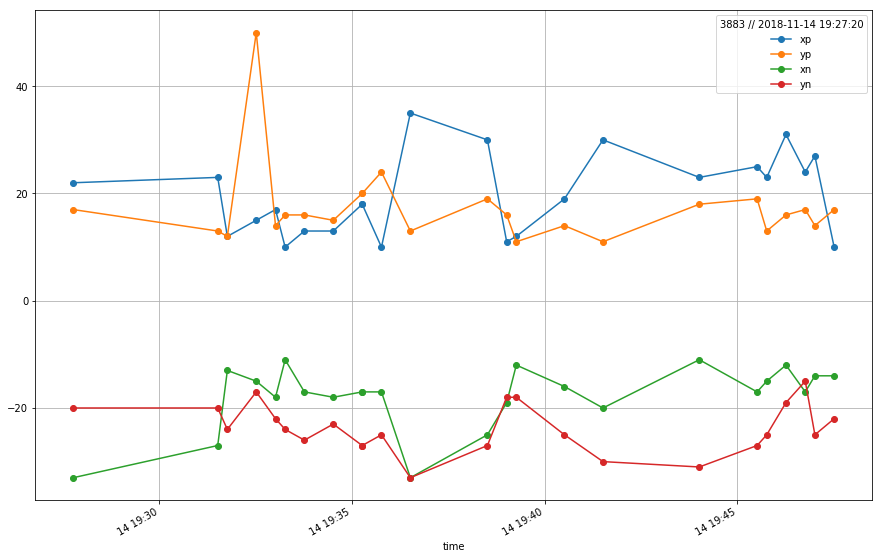

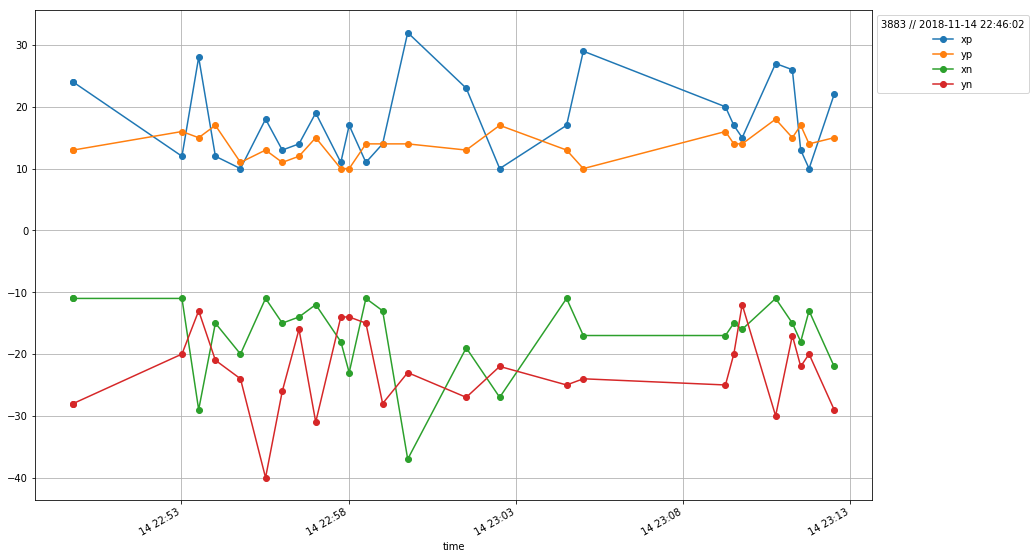

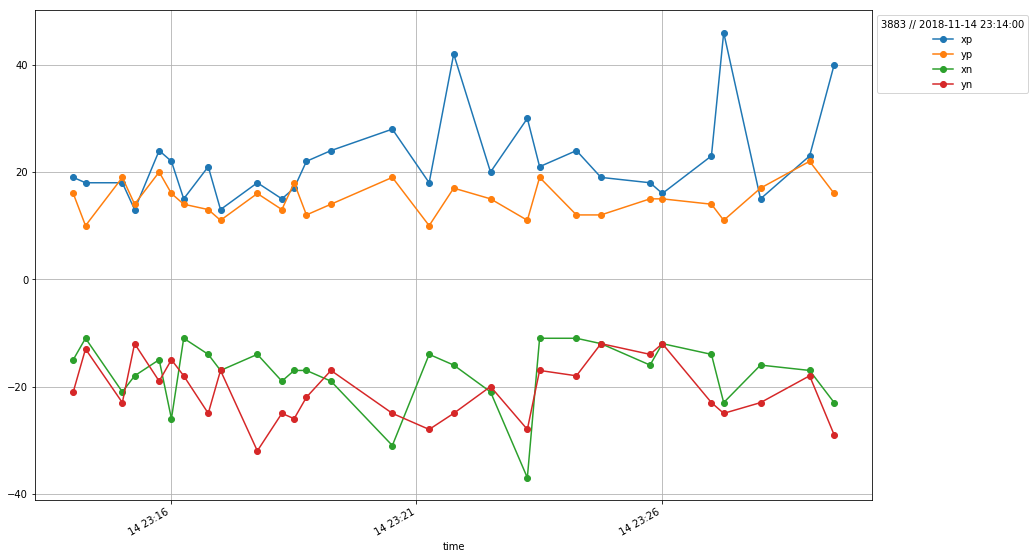

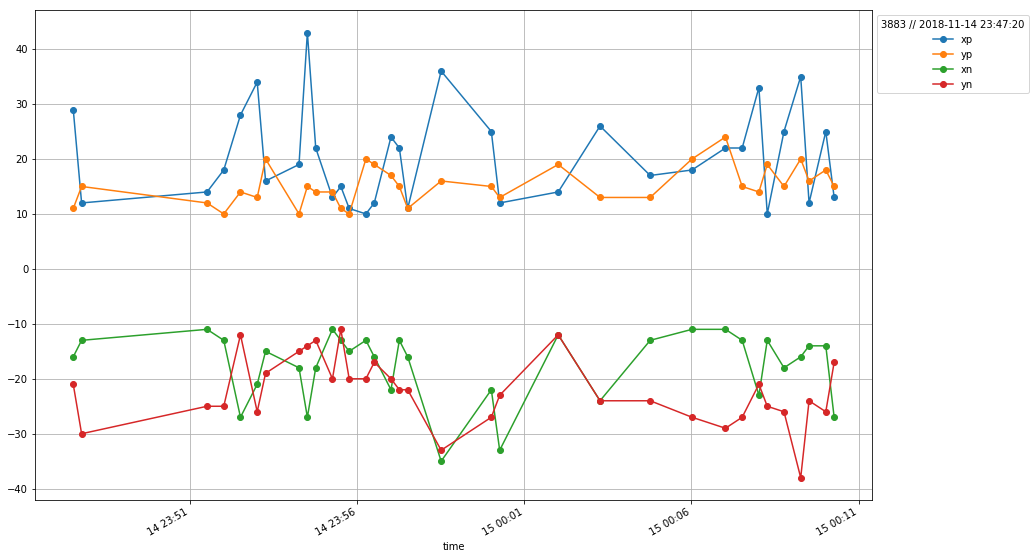

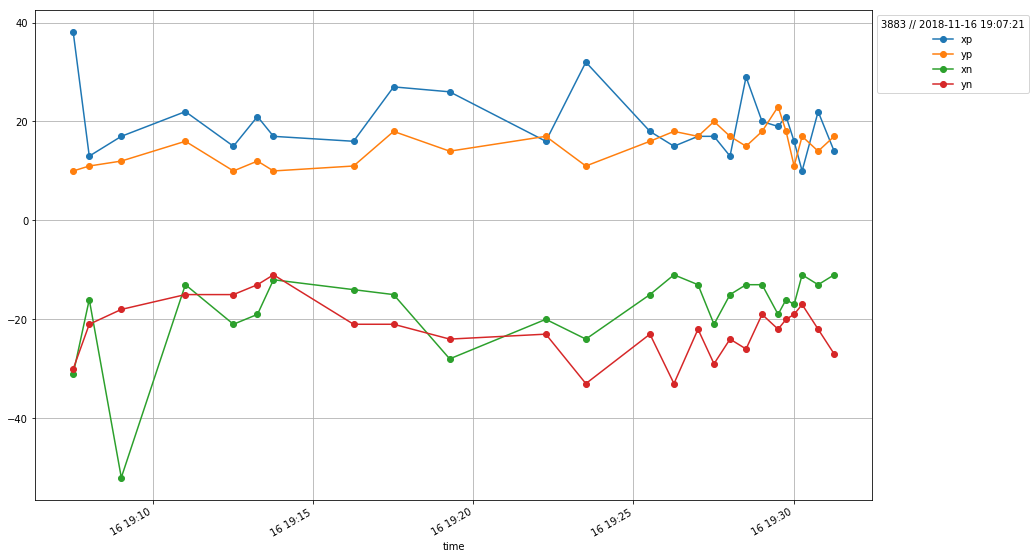

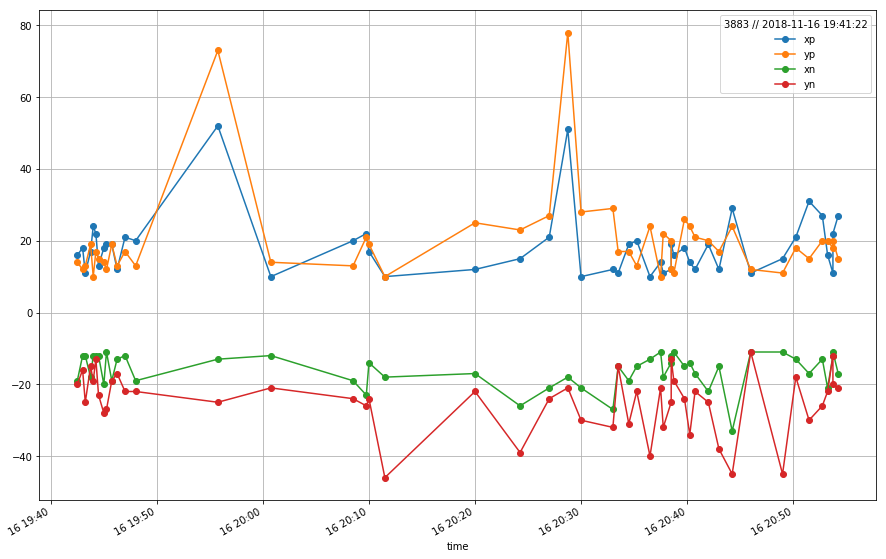

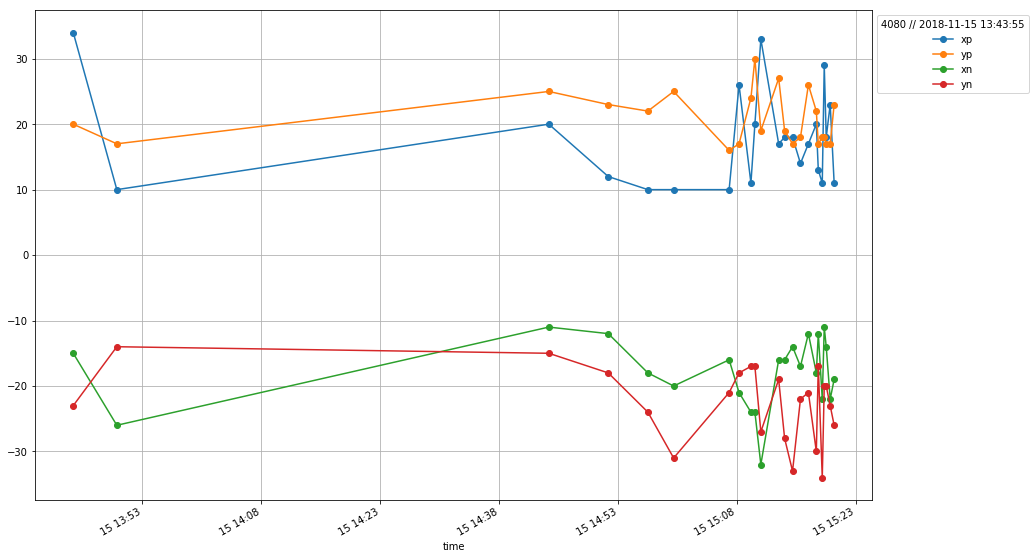

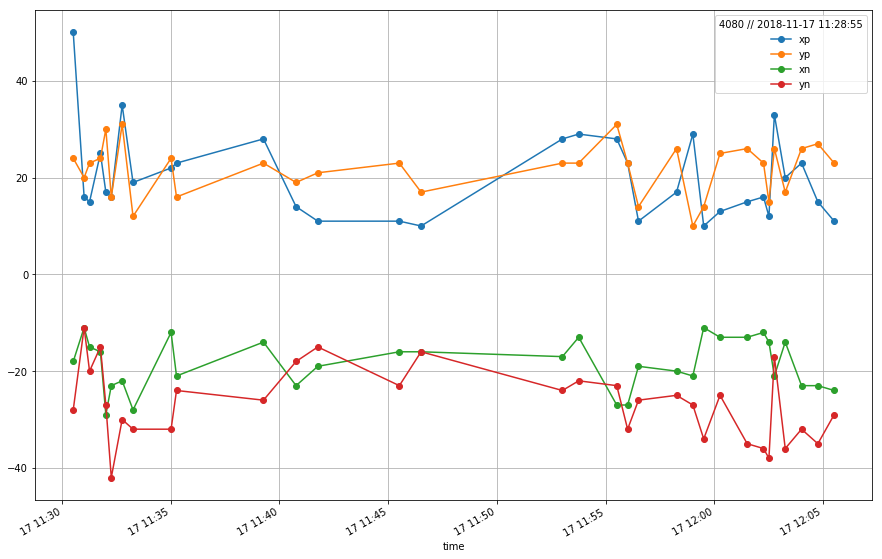

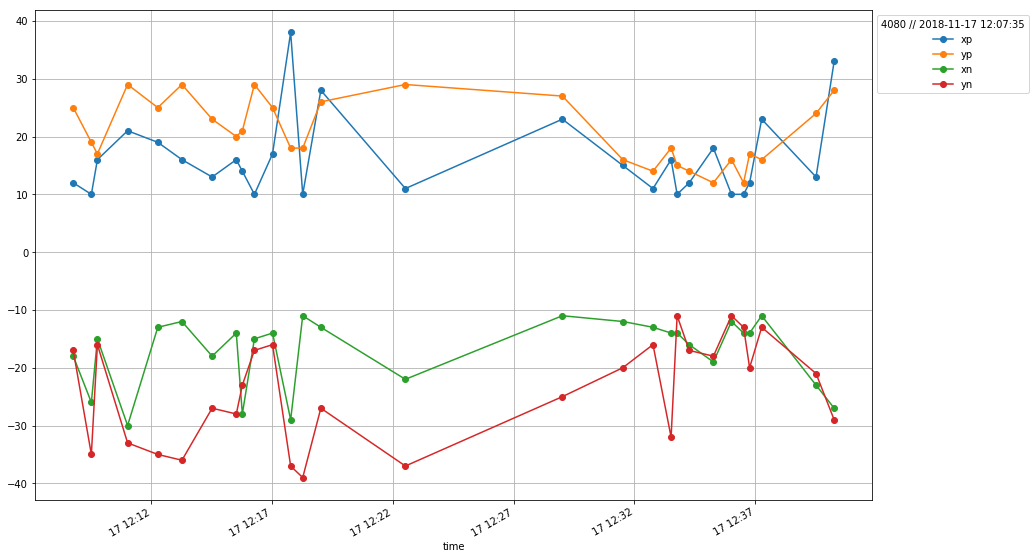

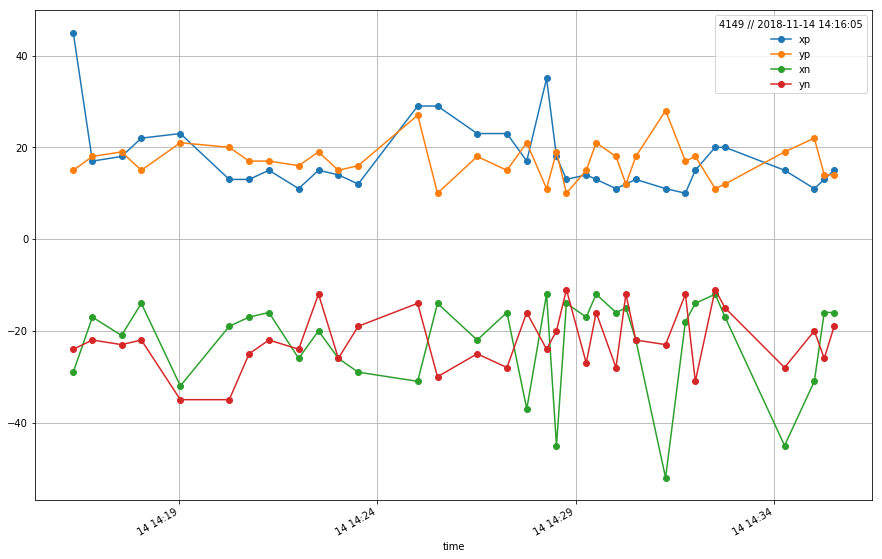

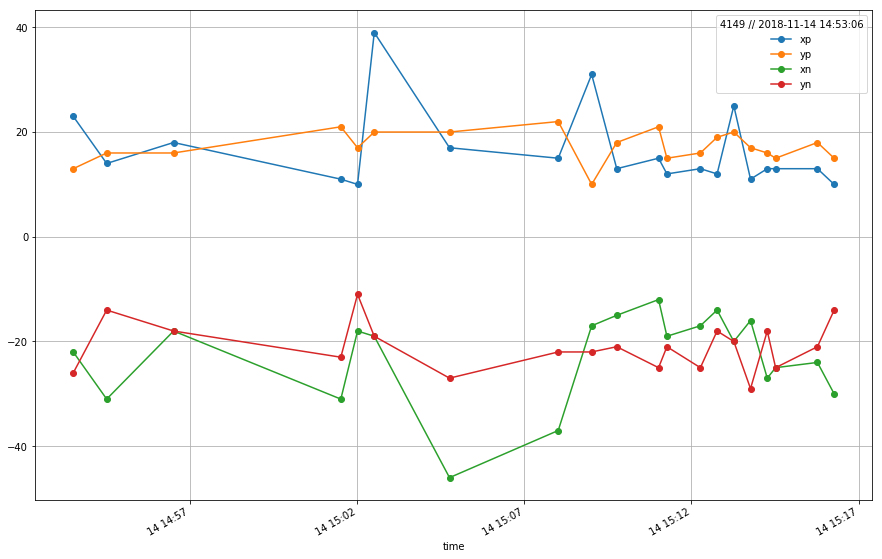

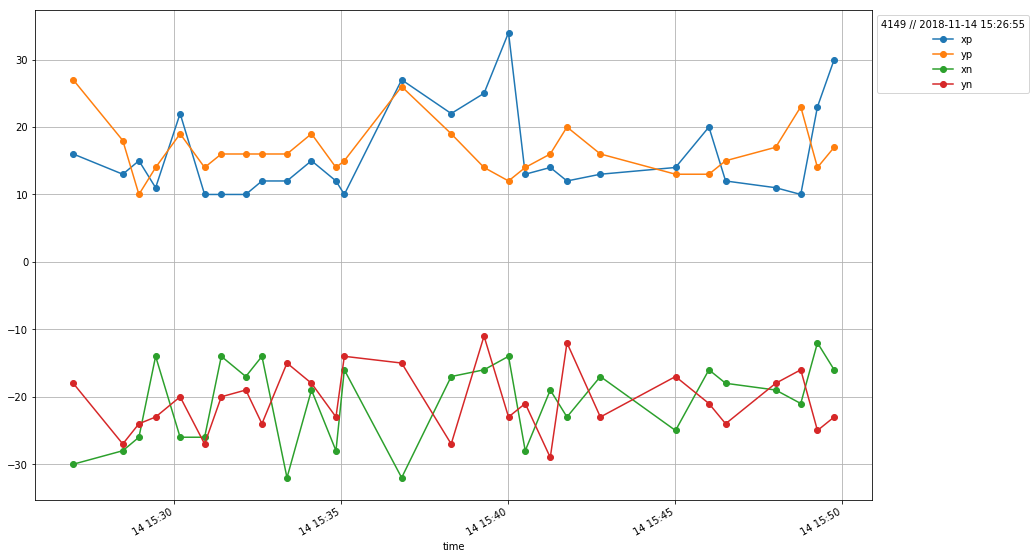

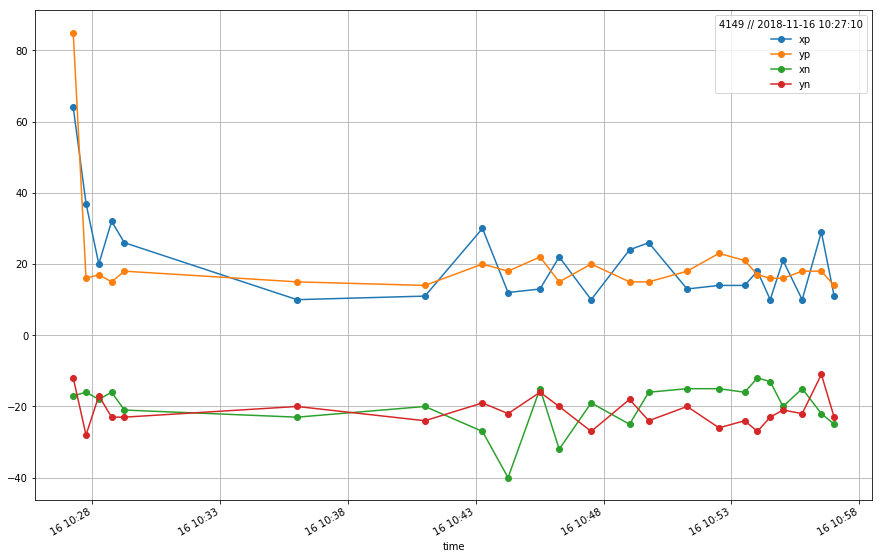

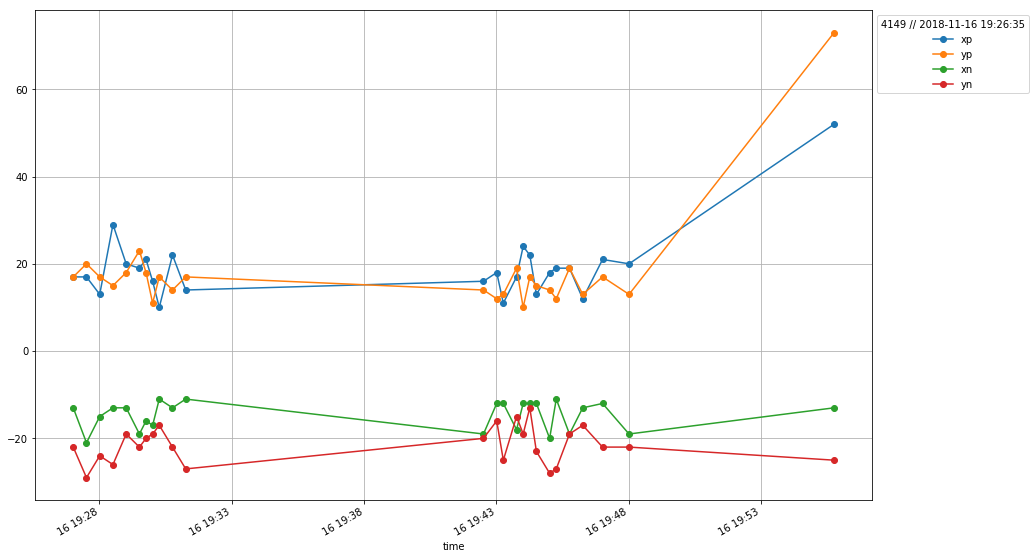

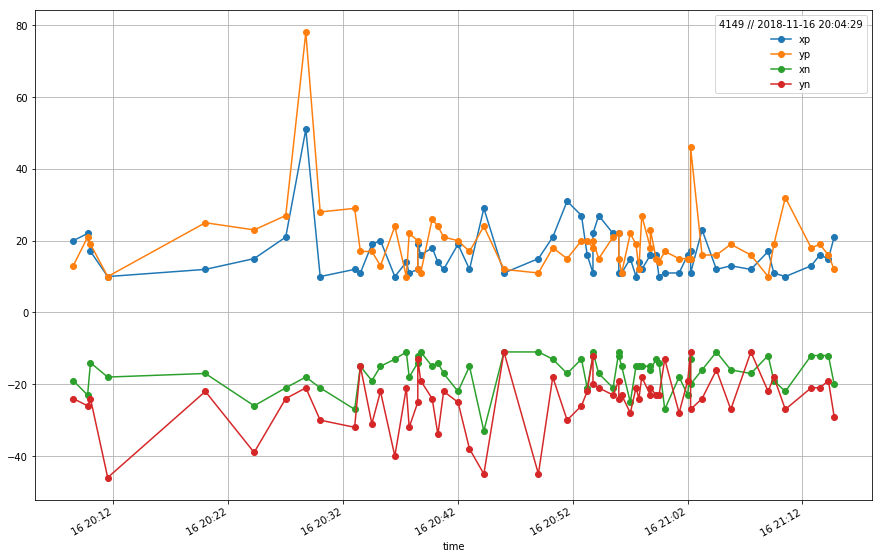

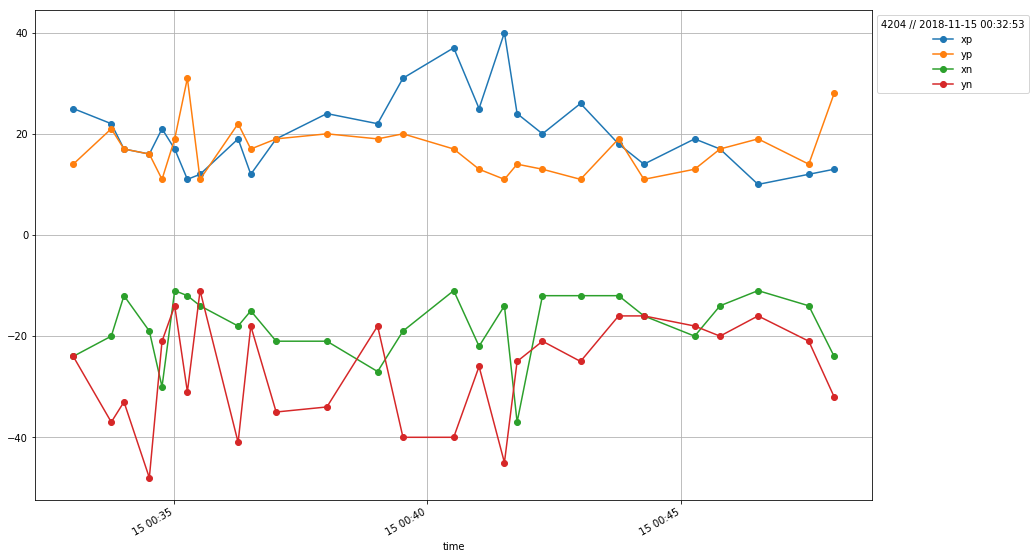

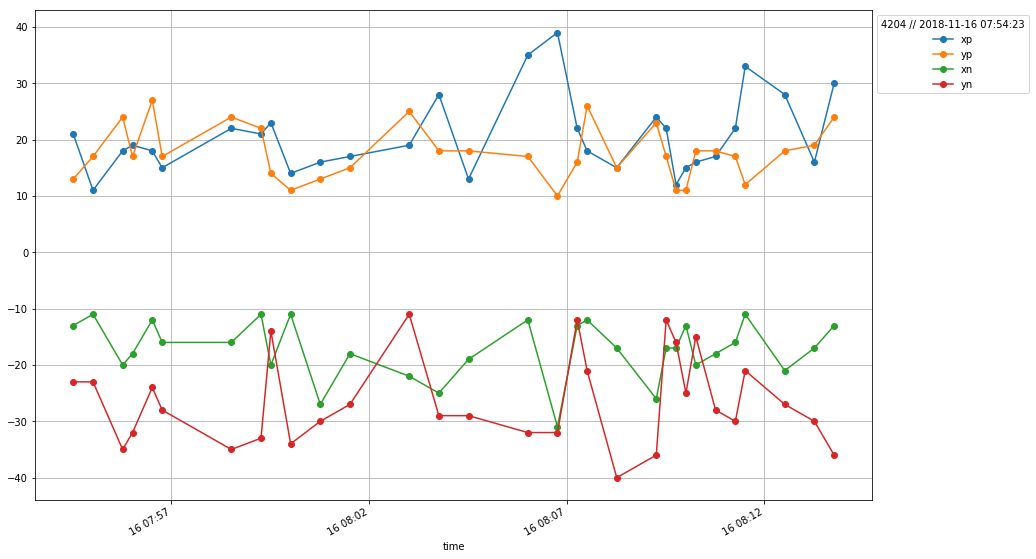

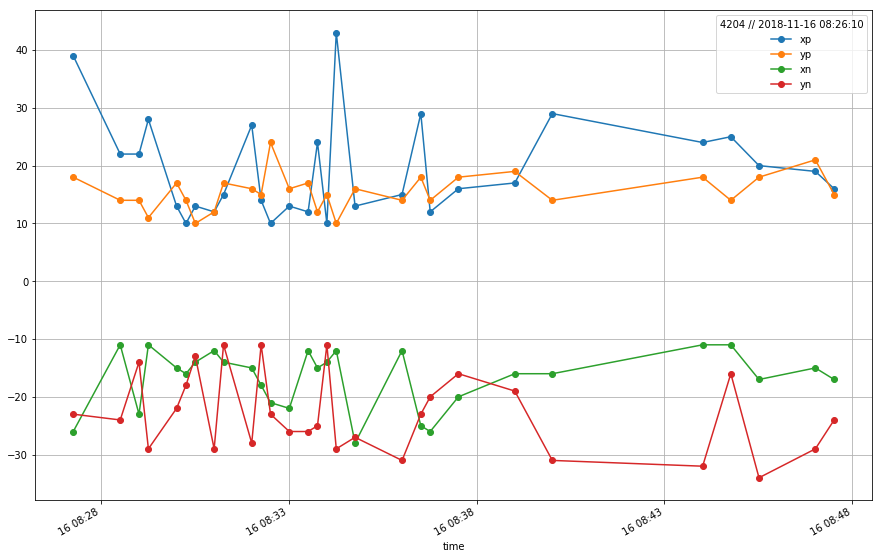

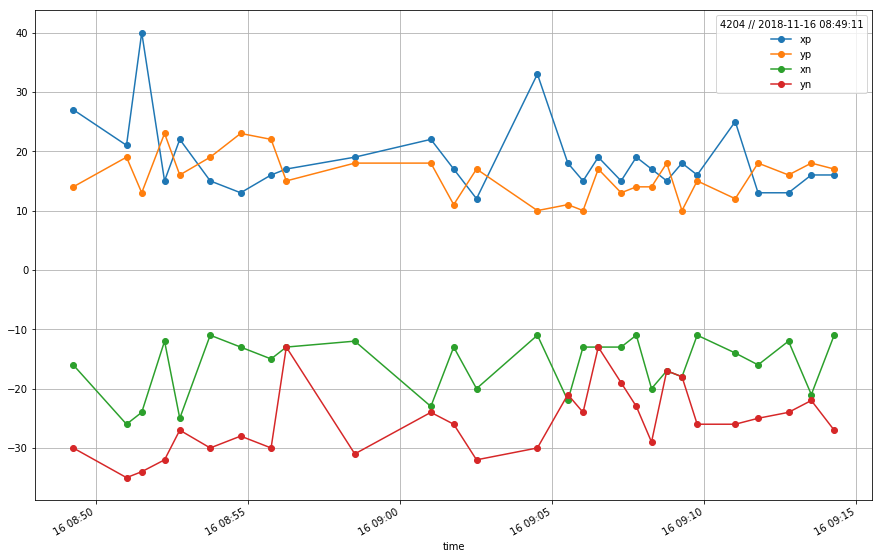

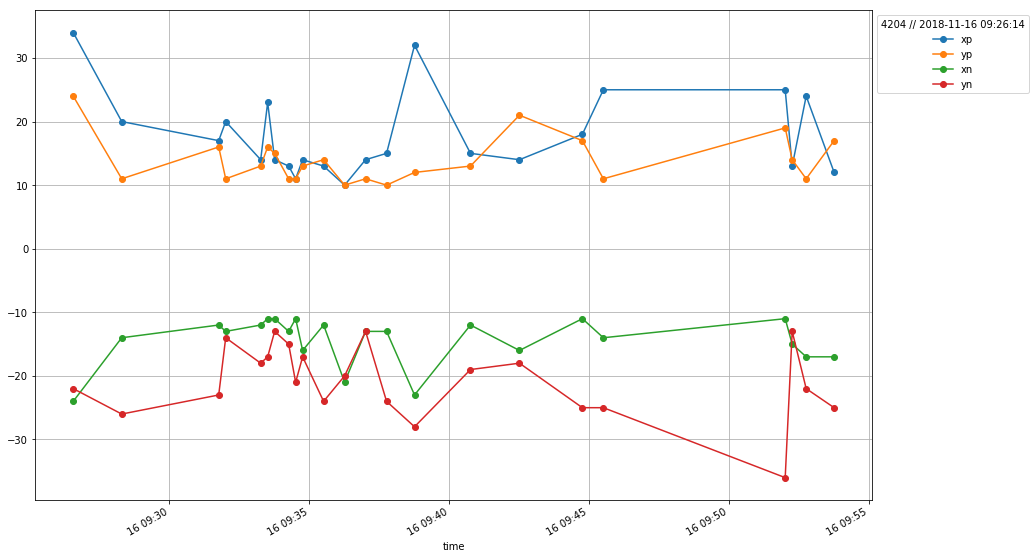

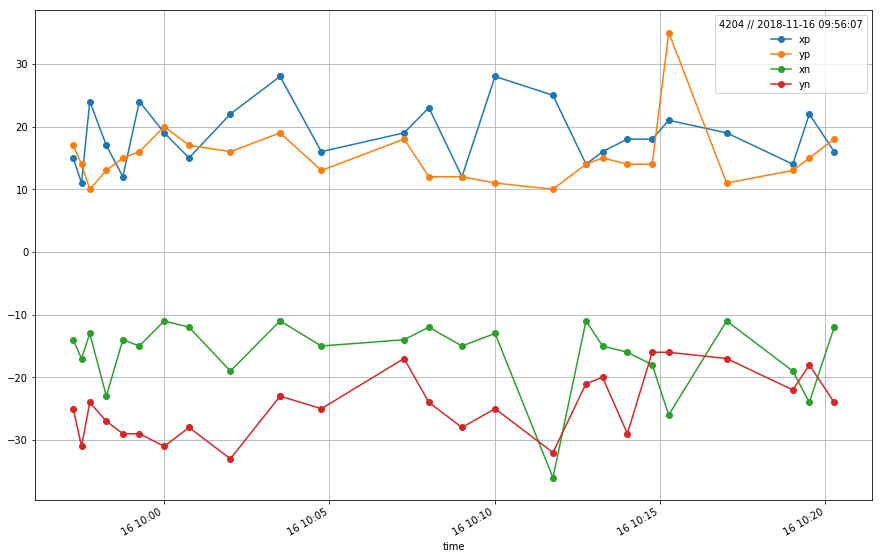

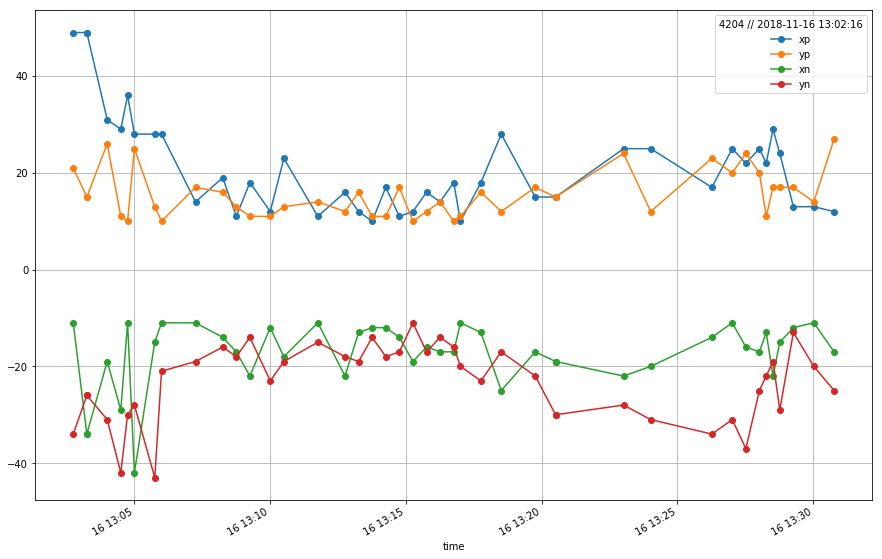

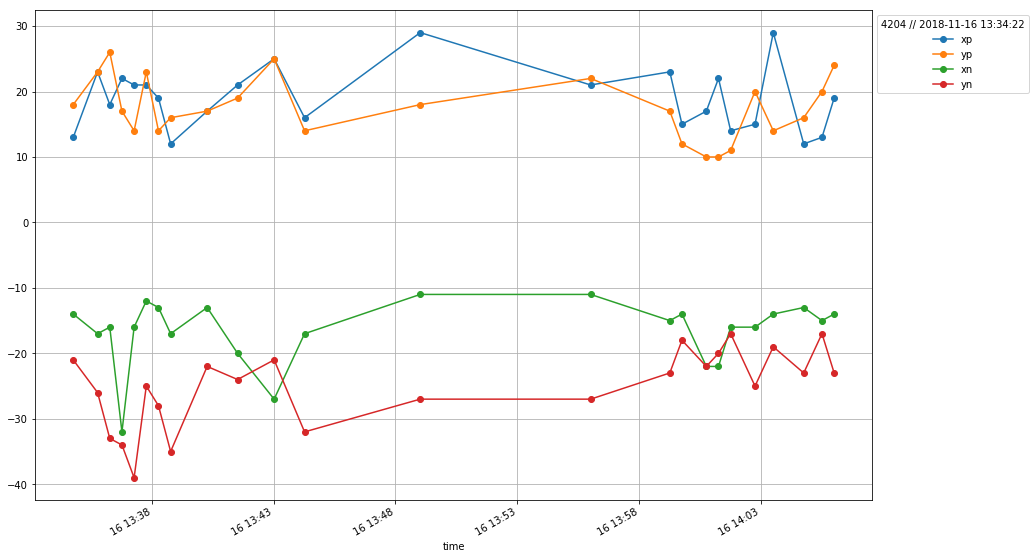

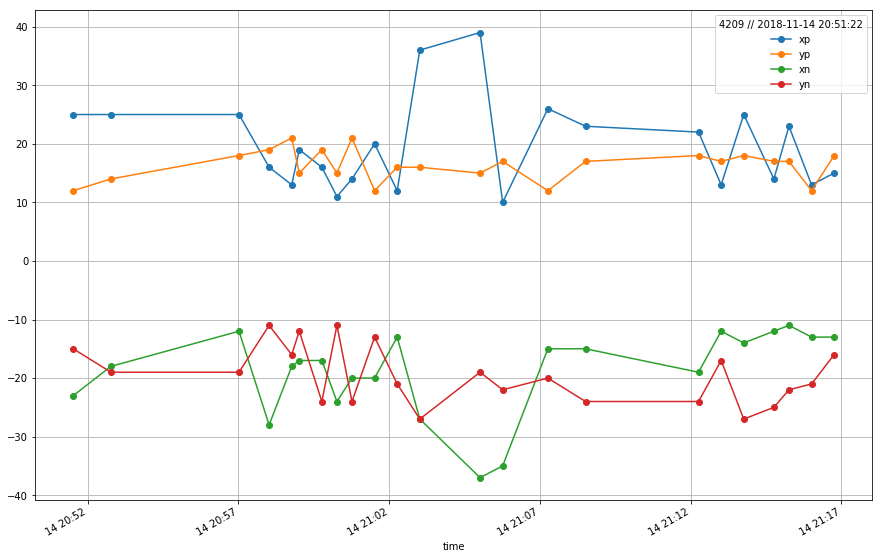

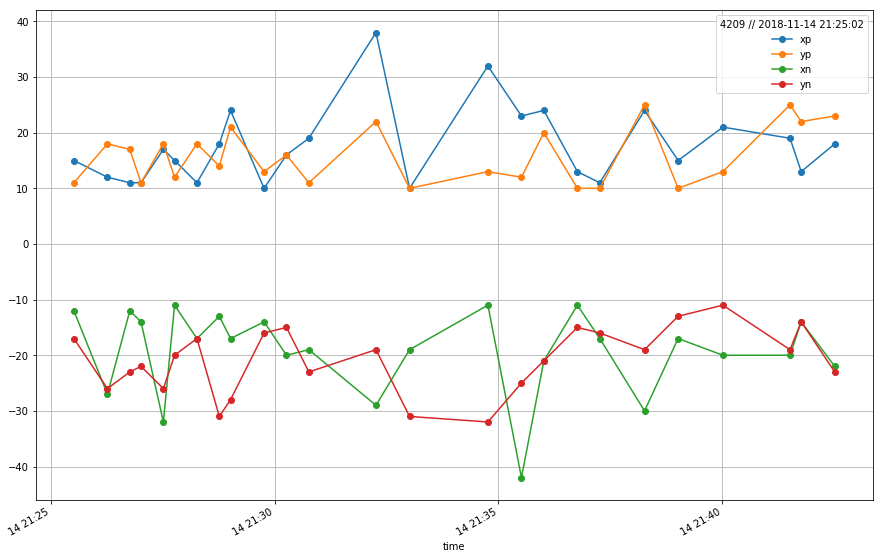

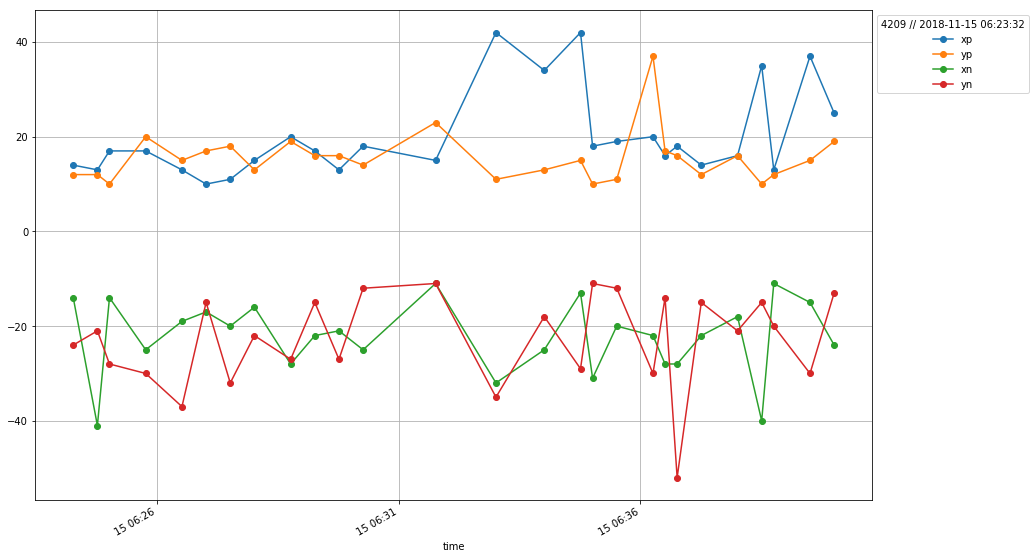

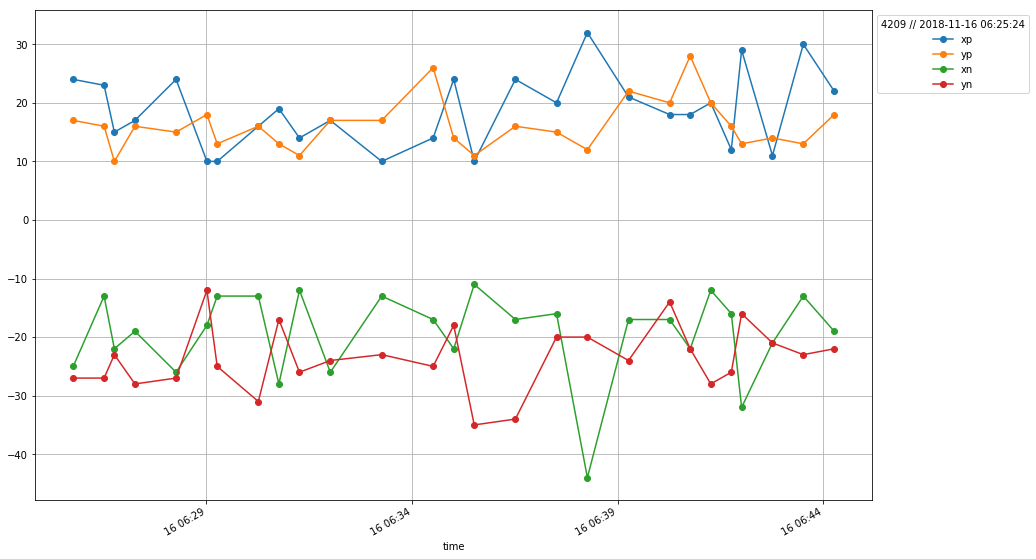

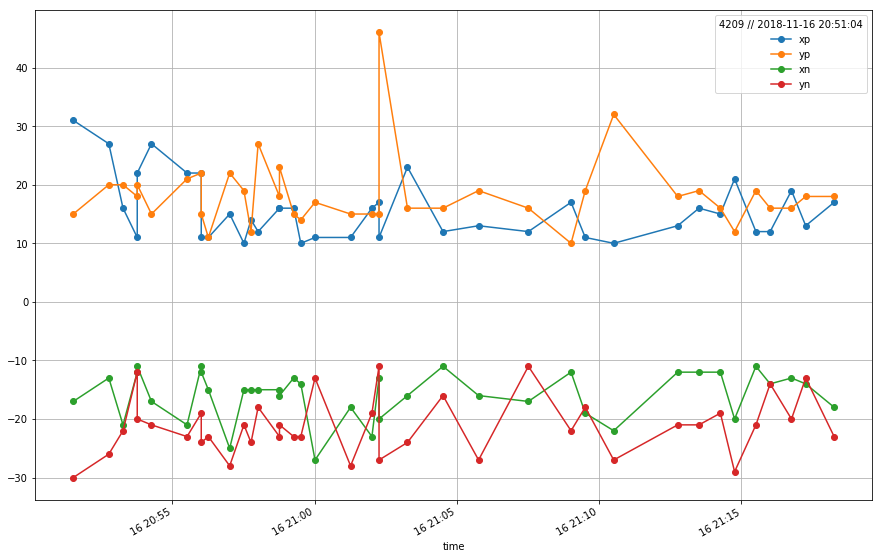

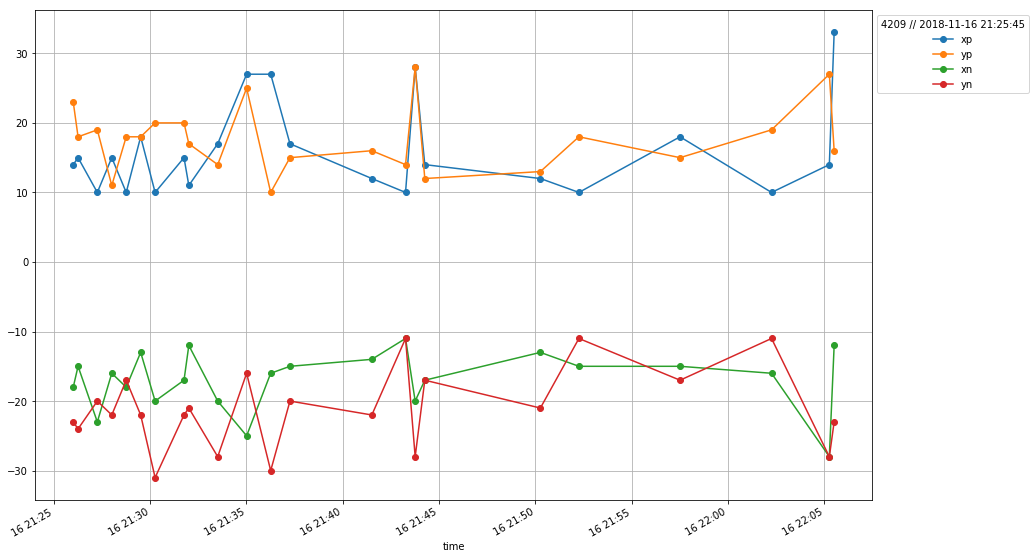

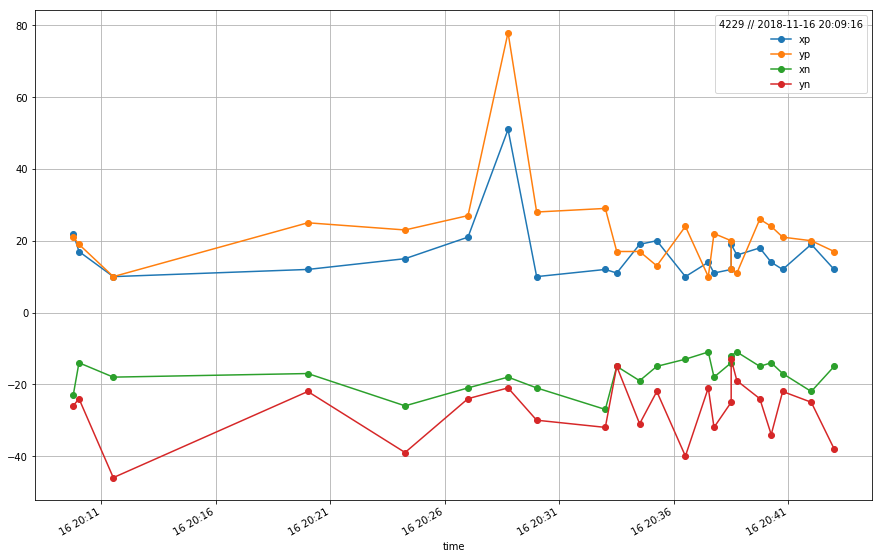

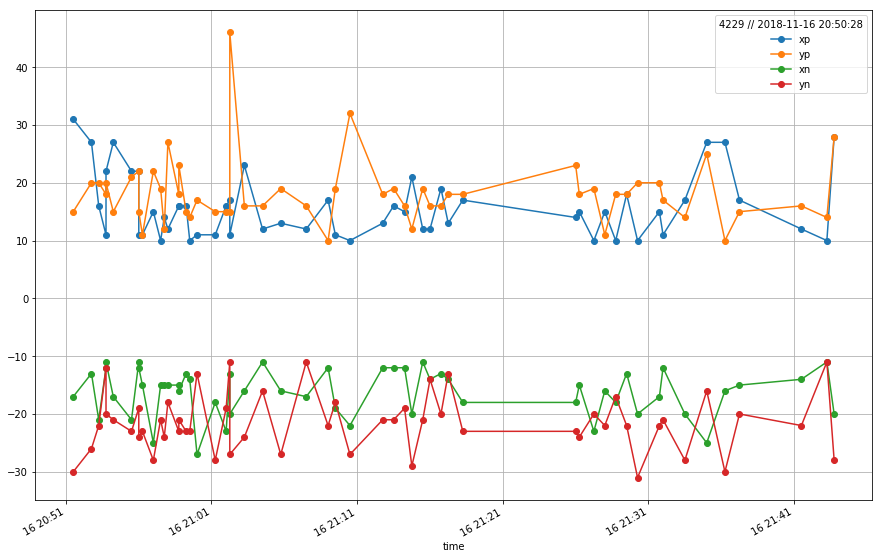

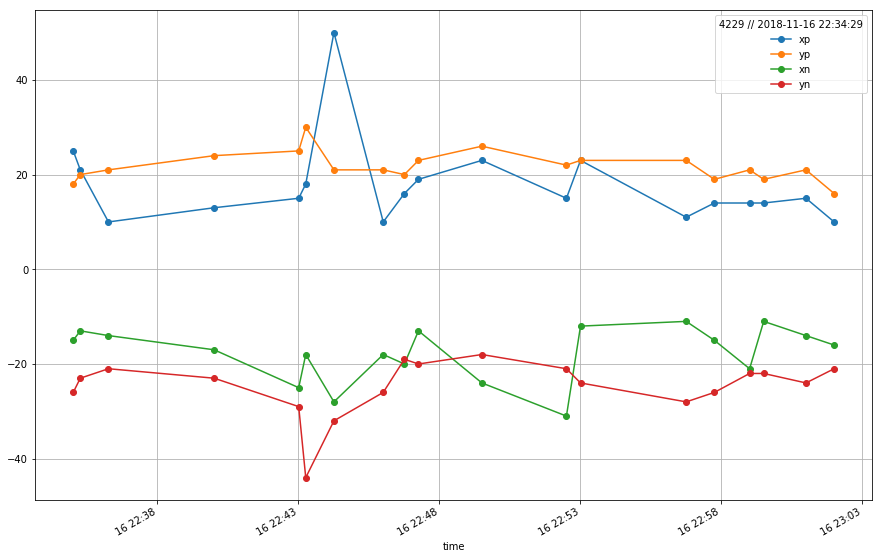

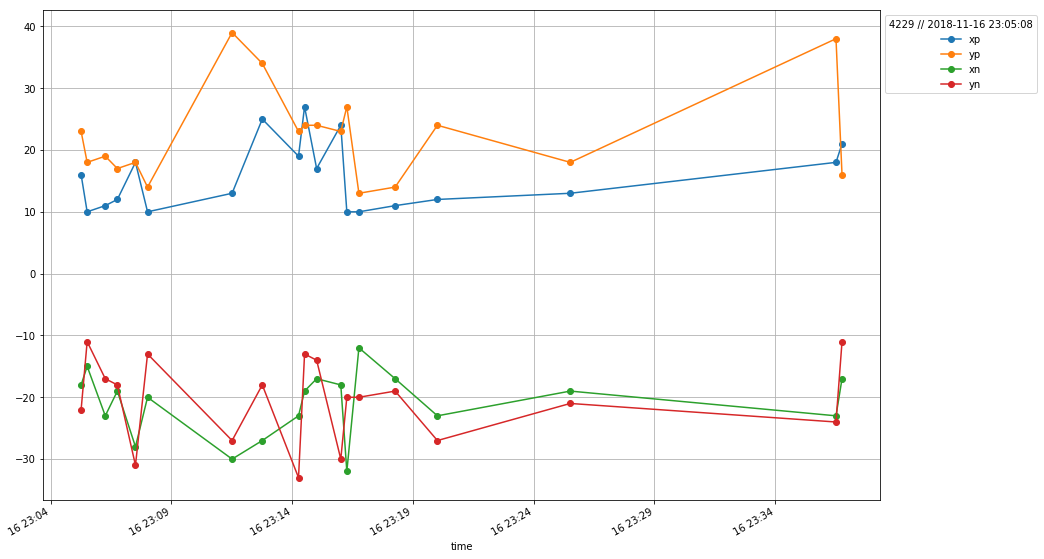

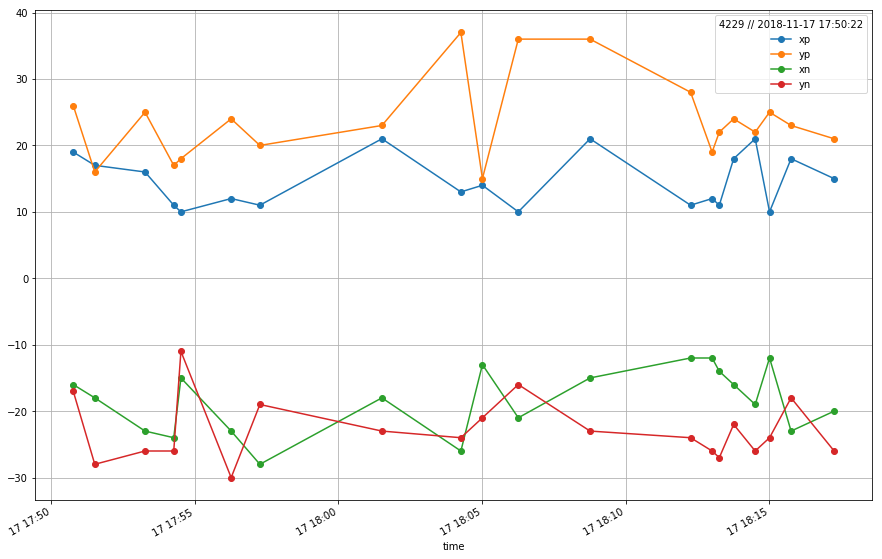

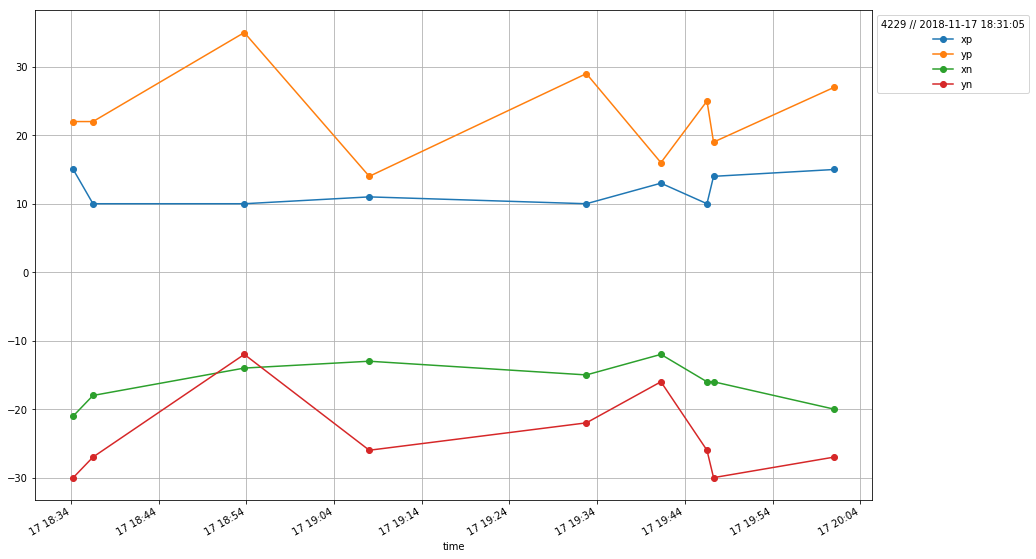

In [15]:
# quando ultrapassa de 20 gráficos é exibido um aviso que pode consumir muita memória
plt.rcParams.update({'figure.max_open_warning': 0})

%matplotlib inline
for i in range(len(df_trip)):
    start_date = df_trip.iloc[i]['start']
    end_date = df_trip.iloc[i]['end']
    mask = (df['time'] > start_date ) & (df['time'] < end_date )
    df_vg = df.loc[mask]
    if df_vg.count()['yn'] != 0:
        df_vg.plot('time',['xp','yp','xn','yn'], marker='o', figsize=(15,10), grid=True).legend(
            title=str(df_trip.iloc[i]['id'])+' // '+str(df_trip.iloc[i]['start']), bbox_to_anchor=(1,1))


#### 4.4 Gráficos Estatística de cada Viagem

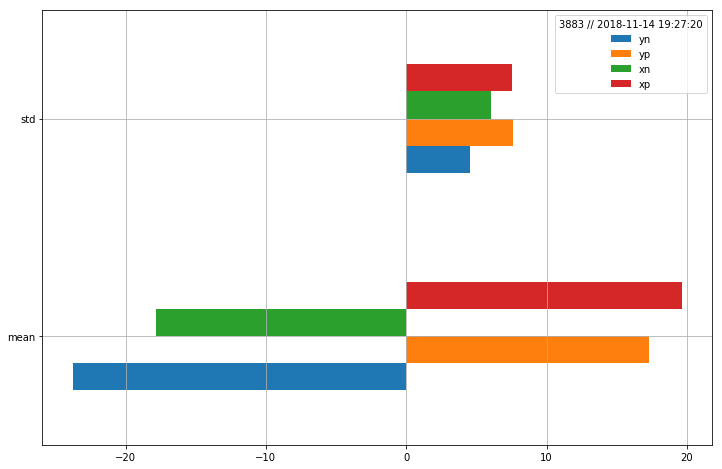

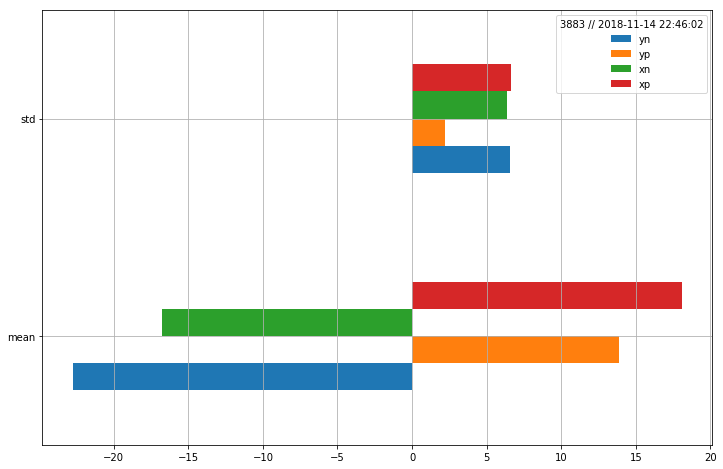

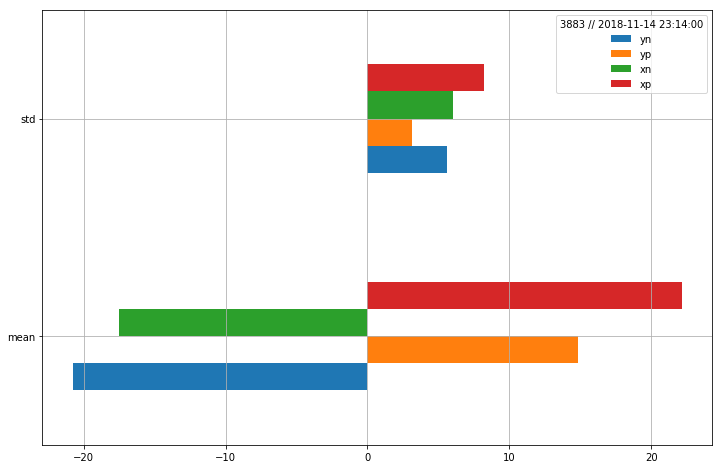

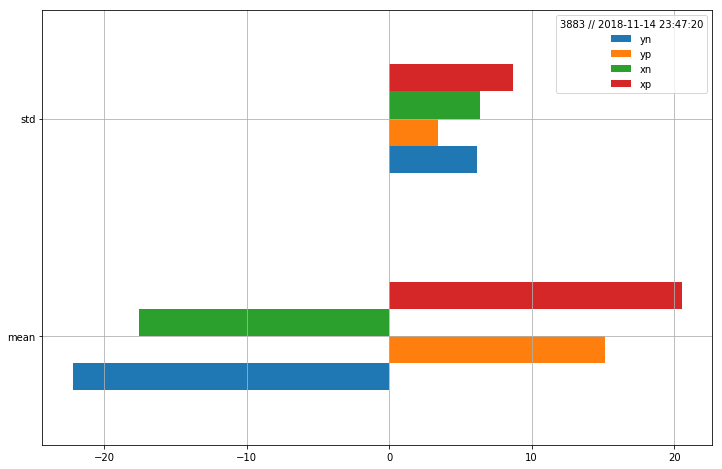

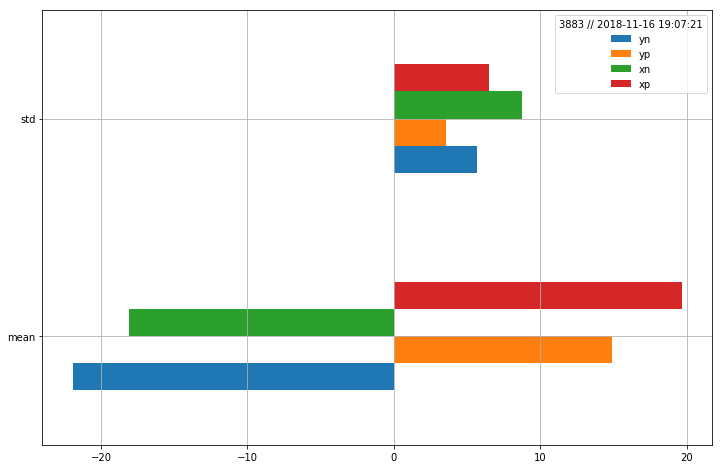

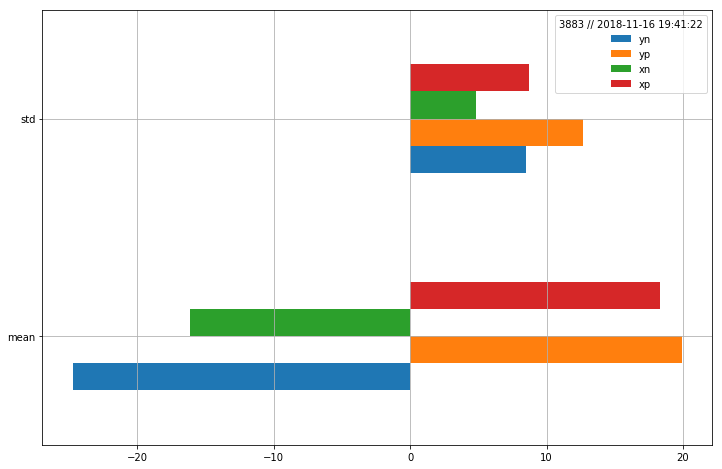

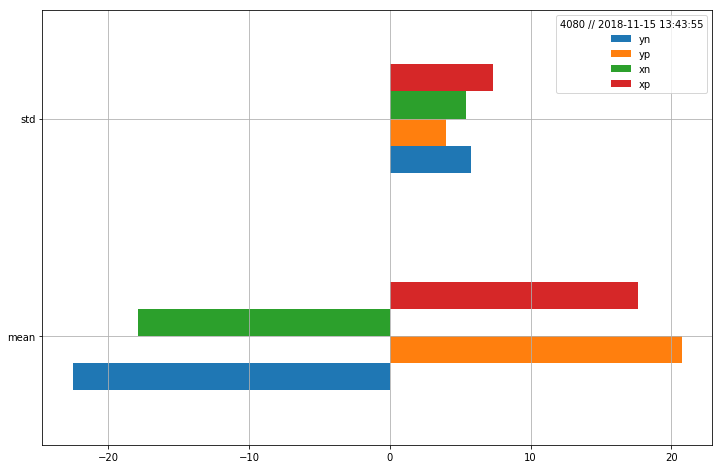

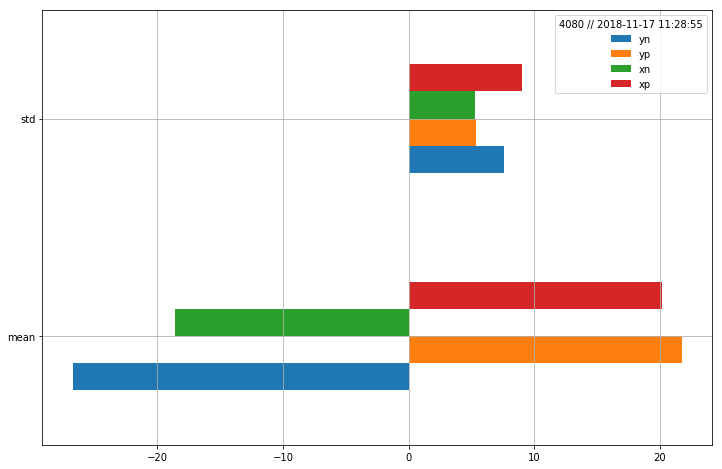

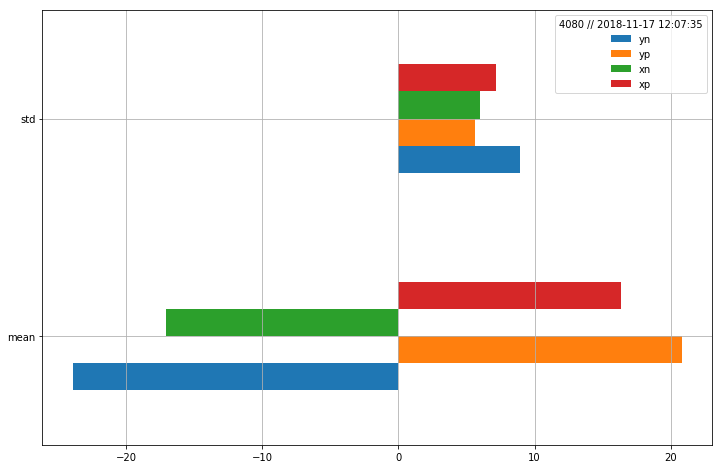

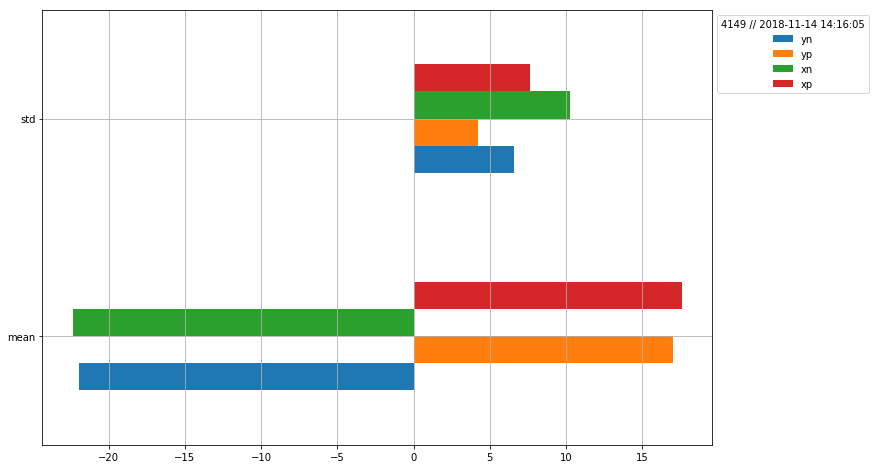

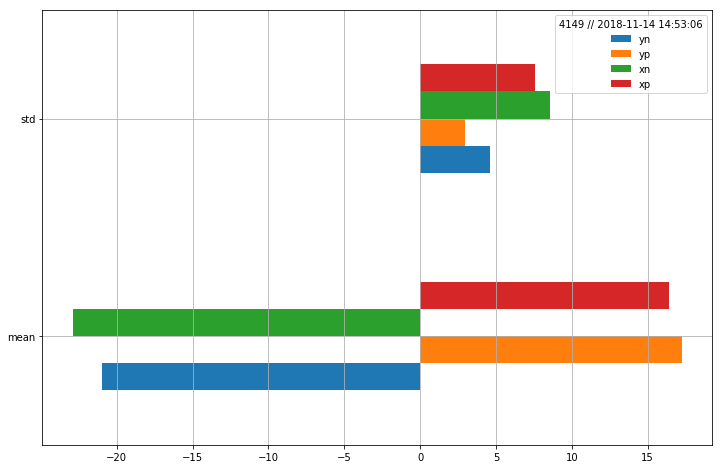

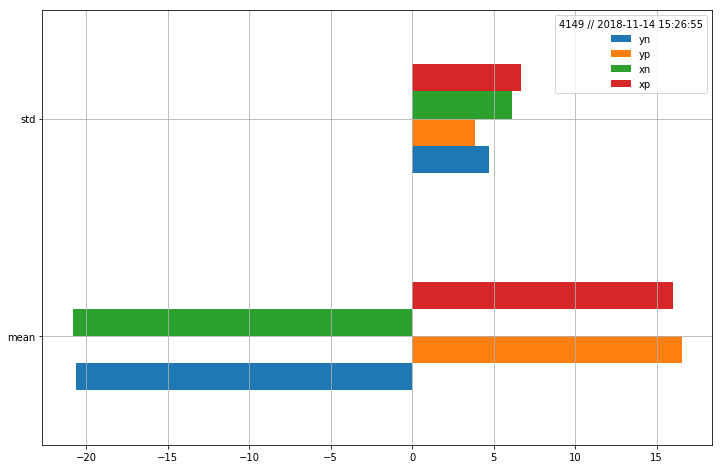

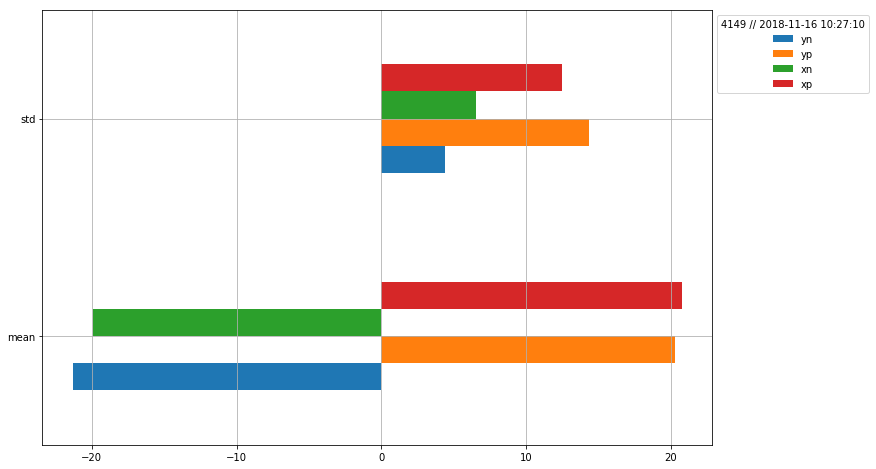

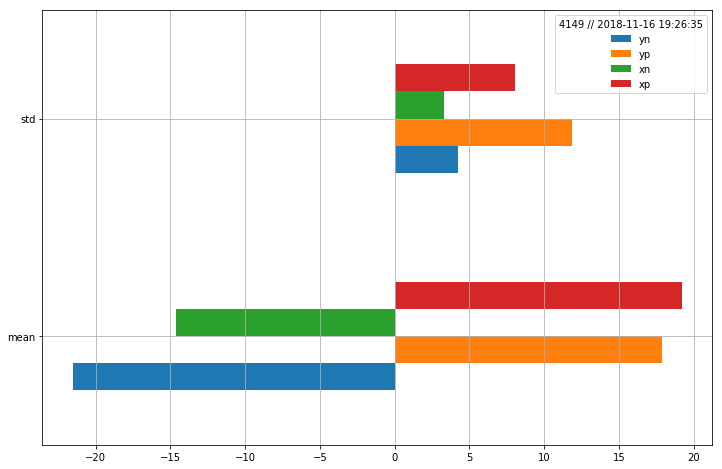

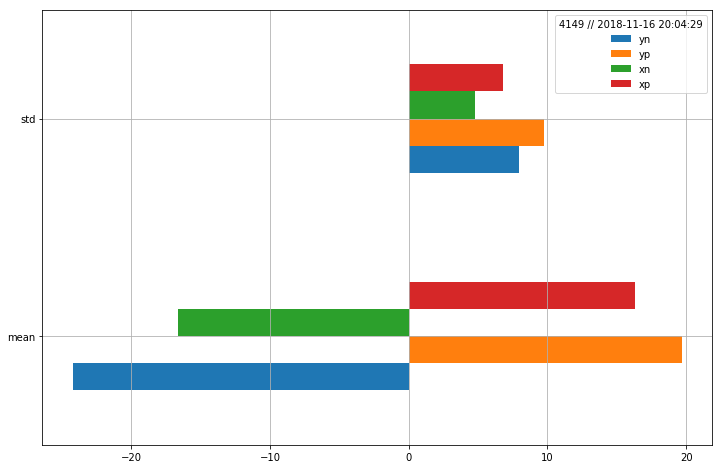

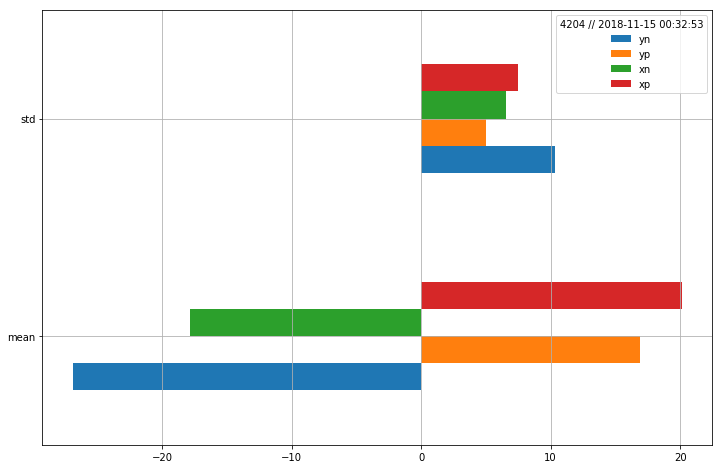

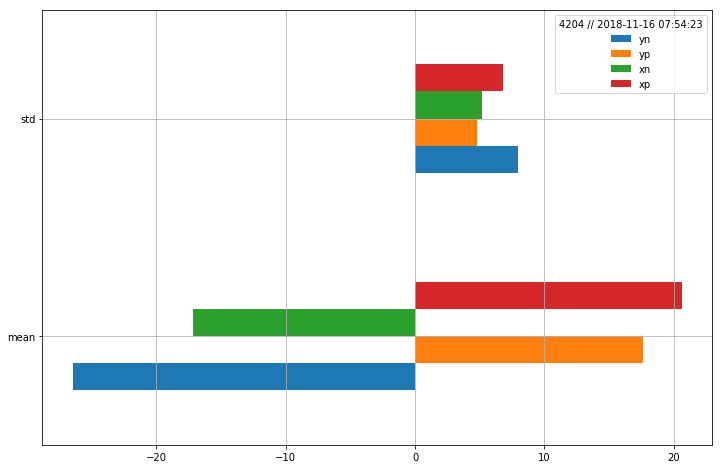

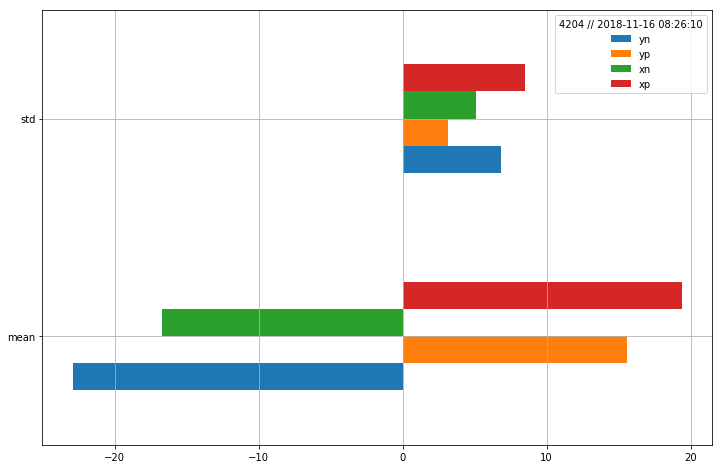

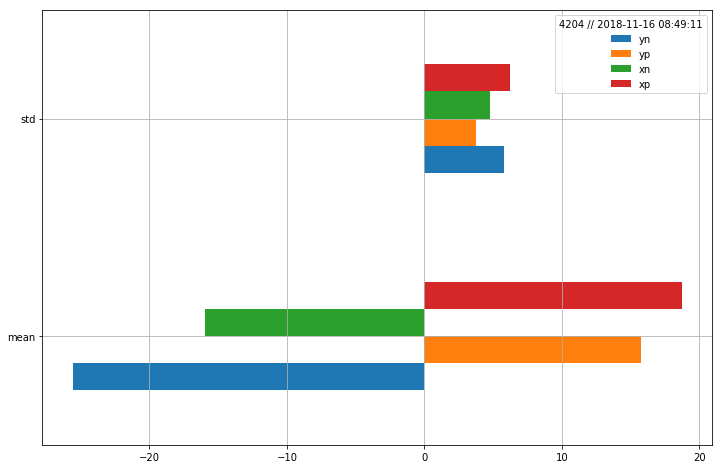

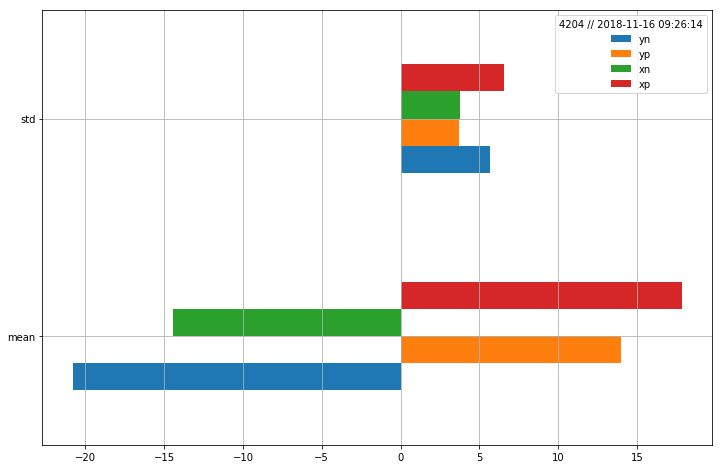

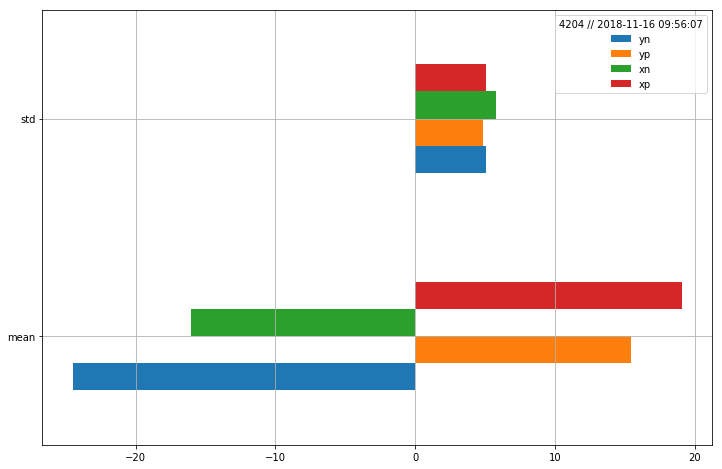

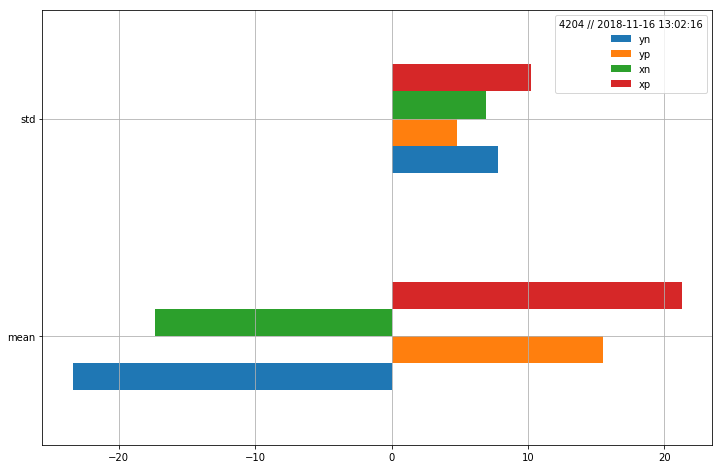

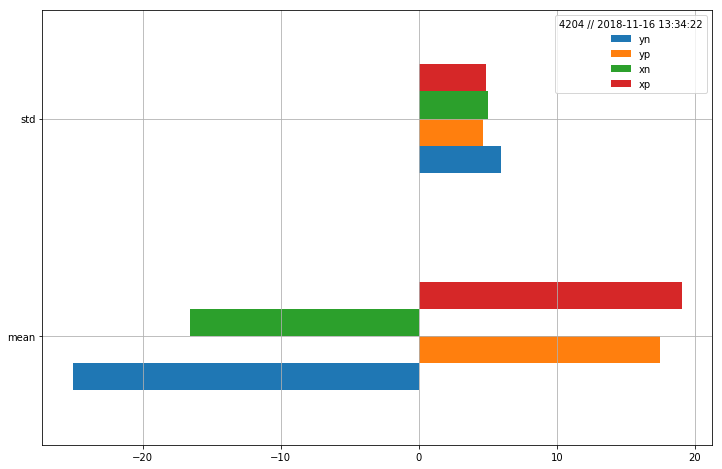

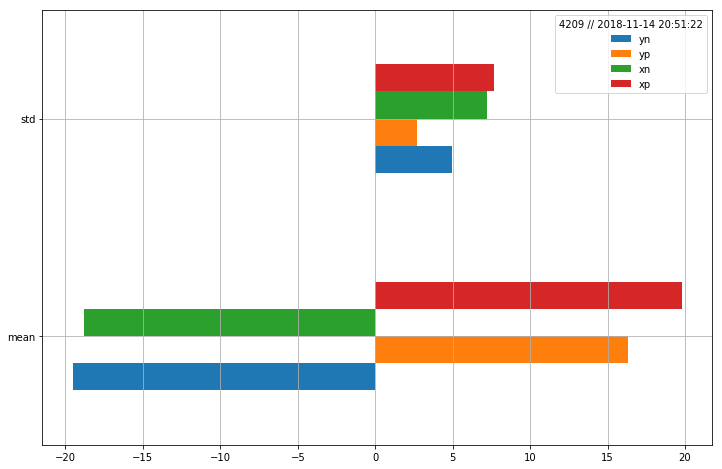

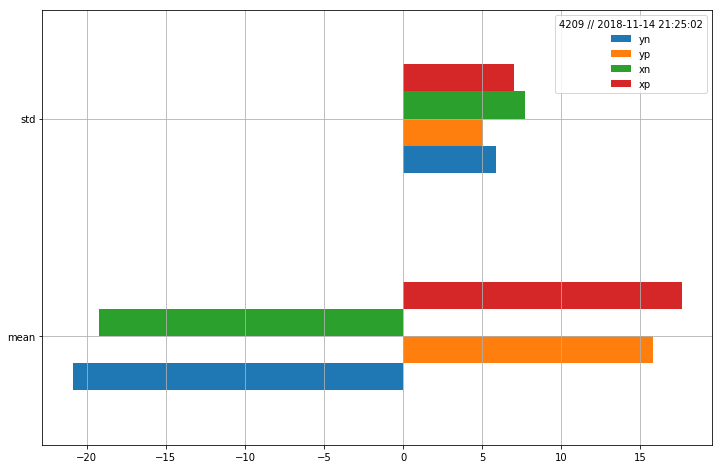

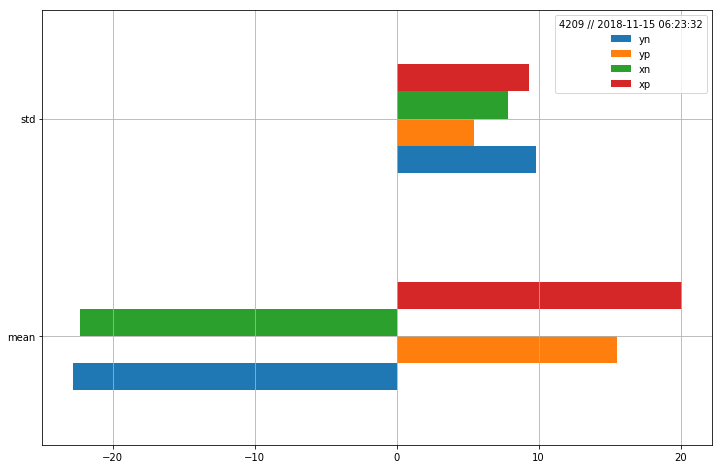

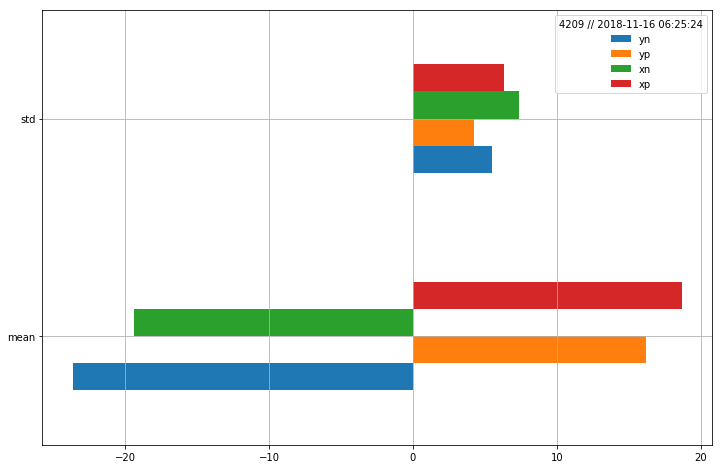

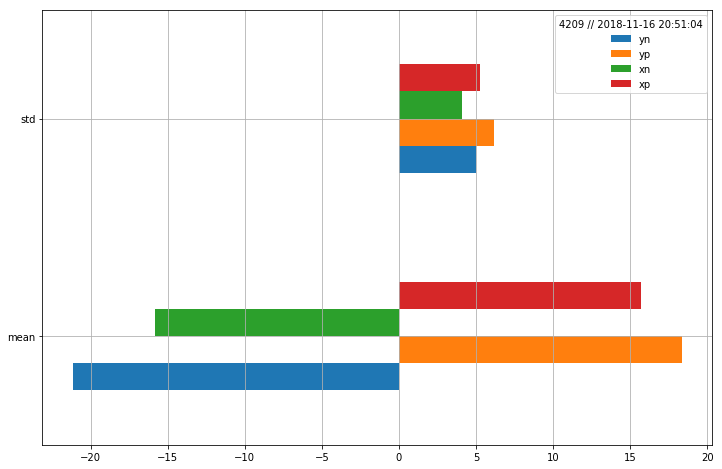

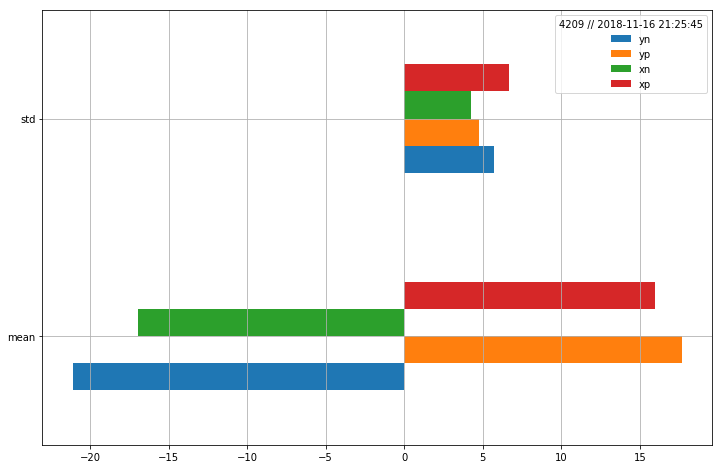

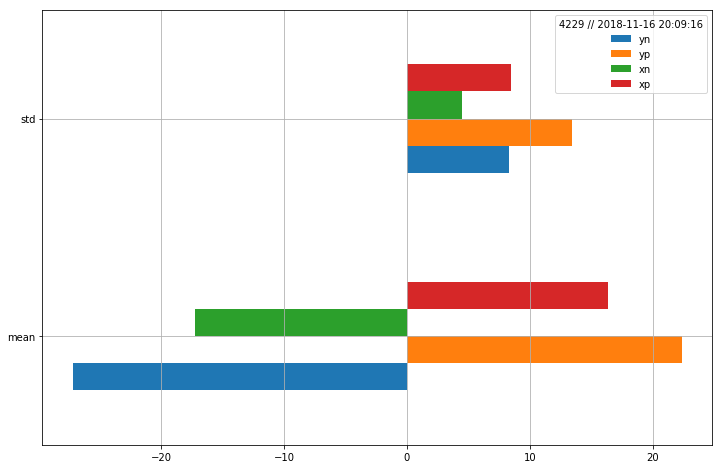

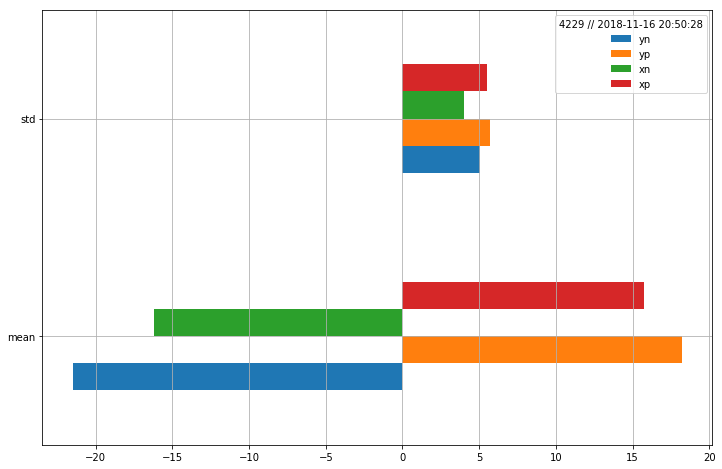

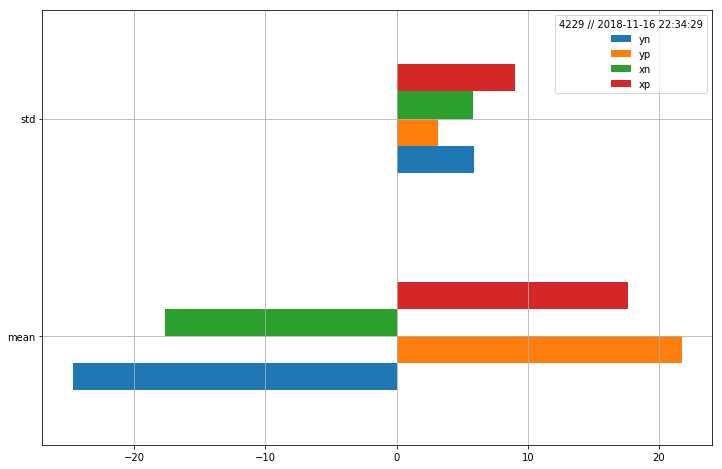

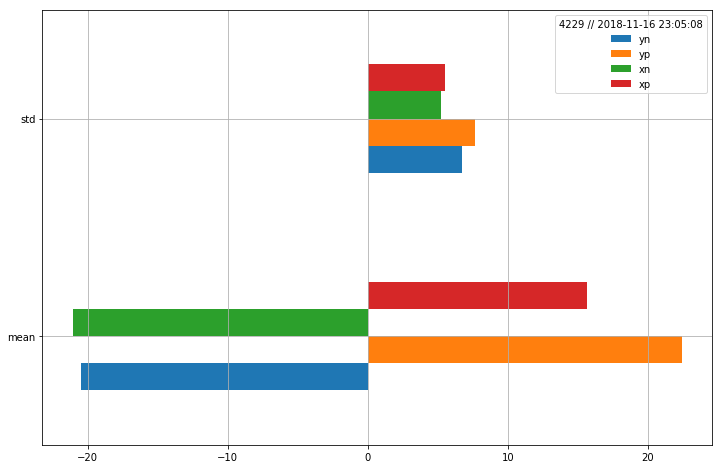

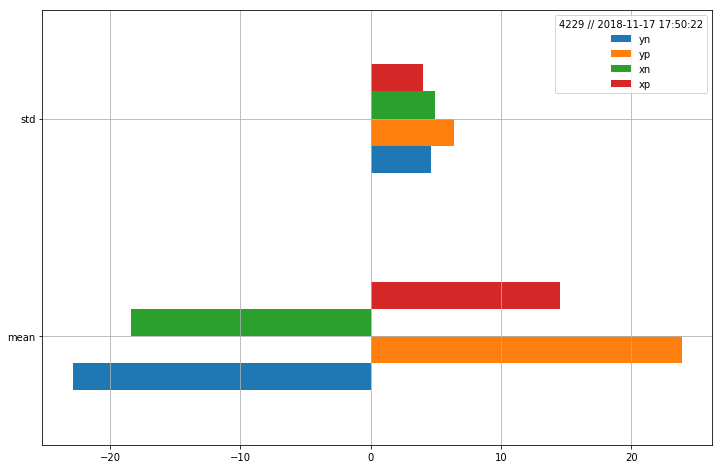

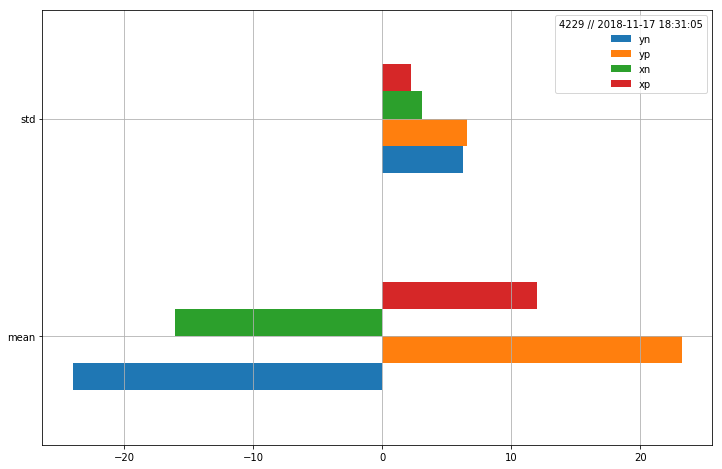

In [16]:
count = 0
for i in range(len(df_trip)):
    start_date = df_trip.iloc[i]['start']
    end_date = df_trip.iloc[i]['end']
    mask = (df['time'] > start_date ) & (df['time'] < end_date )
    df_vg = df.loc[mask]
    if df_vg.count()['yn'] != 0:    
        b = df_vg.agg(['mean', 'std'])
        b[['yn','yp','xn','xp']].plot.barh(figsize=(12,8), grid=True).legend(title=str(df_trip.iloc[i]['id'])+' // '+str(df_trip.iloc[i]['start']), bbox_to_anchor=(1,1))
    count = count + 1

# figsize=(15,10), grid=True).legend(
# title=str(df_trip.iloc[i]['id'])+' // '+str(df_trip.iloc[i]['start']), bbox_to_anchor=(1,1))
